In [362]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Gen Pareto

In [363]:
def gen_gp_pdf(x,loc,scale,shape):
    return np.where(x>loc,1/scale*(1+shape*(x-loc)/scale)**(-1-1/shape),0)

In [364]:
def repar_gen_gp_pdf(x,loc,mean,std):
    shape =1/2-(mean-loc)**2/(2*std**2)
    scale = (mean-loc)/2+(mean-loc)**3/(2*std**2)
    return gen_gp_pdf(x,loc,scale,shape)

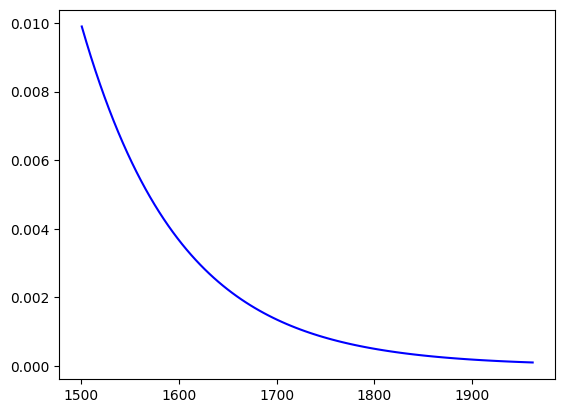

In [365]:
shape=1/1000
scale = 100
loc=1500
law = stats.genpareto(c=shape,scale=scale,loc=loc)
x = np.linspace(law.ppf(0.01),law.ppf(0.99), 100)
plt.plot(x,law.pdf(x),color="blue")
#plt.plot(x,repar_gen_gp_pdf(x,loc,law.mean(),law.std()),color="red")
#plt.plot(x,gen_gp_pdf(x,loc,scale,shape),color="orange")

0.6319368673575714 0.9815272877626293
0.6319366957112229 0.981537641023658


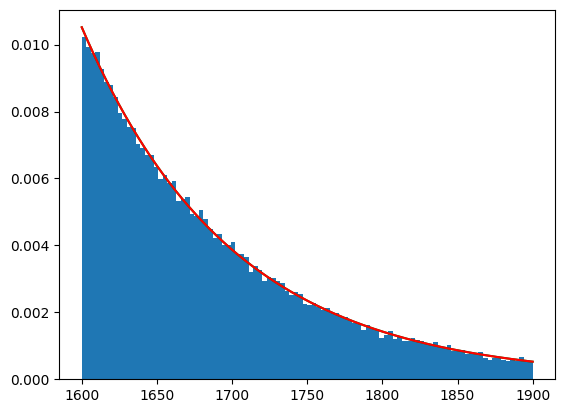

In [366]:
shape=1/1000
scale = 100
loc=1500
law= stats.genpareto(loc=loc,scale=scale,c=shape)
a,b= 1600,1900
#a,b=(a-loc)/scale,(b-loc)/scale
U=np.random.uniform(low=law.cdf(a),high=law.cdf(b),size=100000)
print(np.min(U),np.max(U))
print(law.cdf(a),law.cdf(b))
X =law.ppf(U)
plt.hist(X,bins=100,density=True);
x=np.linspace(a,b,1000)
plt.plot(x,law.pdf(x)/(law.cdf(b)-law.cdf(a)),color='green');
plt.plot(x,gen_gp_pdf(x,loc,scale,shape)/(law.cdf(b)-law.cdf(a)),color='red');

(1004116.0313584695, 1004011.0260571202)

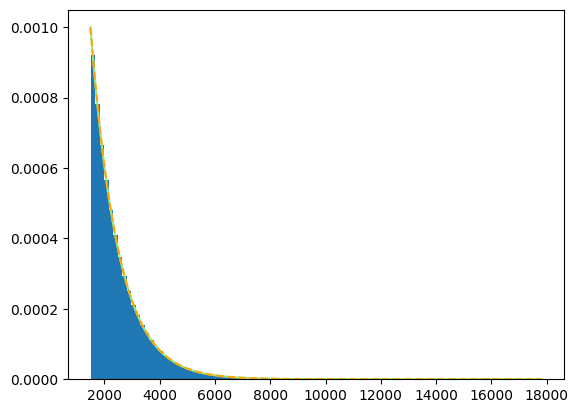

In [367]:
shape=1/1000
scale = 1000
loc=1500
test=stats.genpareto(loc=loc,c=shape,scale = scale).rvs(10000000)
plt.hist(test,bins=100,density=True)
x=np.linspace(np.min(test),np.max(test),1000)
plt.plot(x,stats.genpareto(loc=loc,c=shape,scale = scale).pdf(x),color="lightgreen")
mean,std=np.mean(test),np.std(test)
plt.plot(x,repar_gen_gp_pdf(x,loc,mean,std),color="orange",linestyle="--")
np.std(test),scale**2/(1-shape)**2/(1-2*shape)


# Log Normal

In [368]:
def log_normal_pdf(x,loc,mu,sigma):
    return np.where(x>loc,1/((x-loc)*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x-loc)-mu)**2/(2*sigma**2)),0)

In [369]:
def repar_log_normal_pdf(x,loc,mean,std):
    sigma = np.sqrt(np.log(1+std**2/(mean-loc)**2))
    mu = np.log((mean-loc)**2/np.sqrt((mean-loc)**2+std**2))
    return log_normal_pdf(x,loc,mu,sigma)


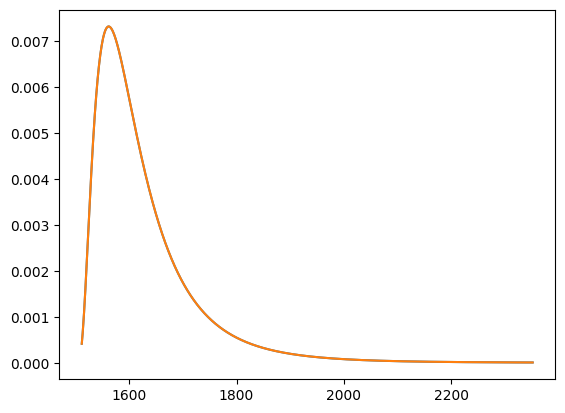

In [370]:
sigma=np.log(2)
mu=np.log(100)
loc=1500
law = stats.lognorm(s=sigma,scale=np.exp(mu),loc=loc)
x = np.linspace(law.ppf(0.001),law.ppf(0.999),1000)

plt.plot(x,law.pdf(x))
plt.plot(x,log_normal_pdf(x,loc,mu,sigma))

0.00044910716588513594 0.09309301464411329
0.0004469886430373935 0.09309604798243942


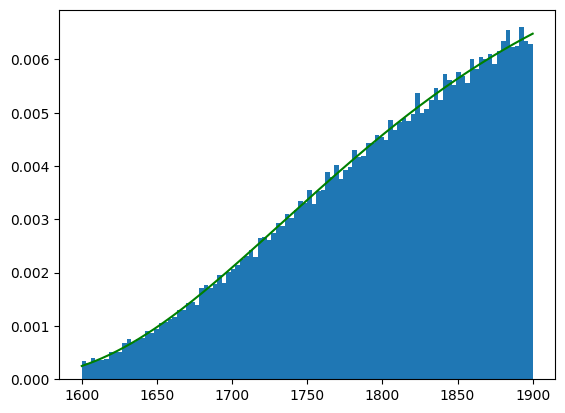

In [371]:
shape=np.log(2)
scale = np.log(1000)
loc=1500
law= stats.lognorm(loc=loc,scale=np.exp(scale),s=shape)
a,b= 1600,1900
#a,b=(a-loc)/scale,(b-loc)/scale
U=np.random.uniform(low=law.cdf(a),high=law.cdf(b),size=100000)
print(np.min(U),np.max(U))
print(law.cdf(a),law.cdf(b))
X =law.ppf(U)
plt.hist(X,bins=100,density=True);
x=np.linspace(a,b,1000)
plt.plot(x,law.pdf(x)/(law.cdf(b)-law.cdf(a)),color='green');
#lt.plot(x,gen_gp_pdf(x,loc,scale,shape)/(law.cdf(b)-law.cdf(a)),color='red');

In [372]:
mean_genpareto = loc+scale*(np.exp(shape**2)-1)**(1/2)*np.exp(shape**2/2)

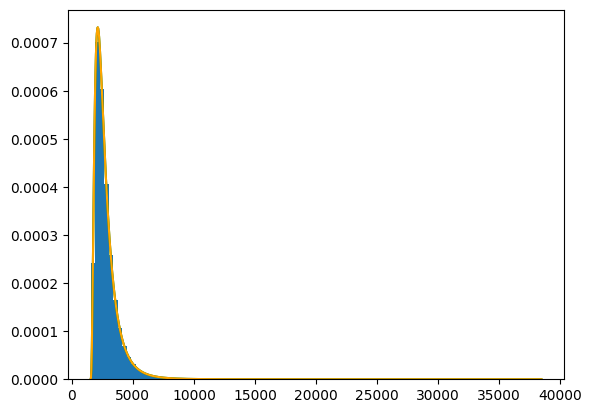

In [373]:
shape=np.log(2)
scale = np.log(1000)
loc=1500
law=stats.lognorm(s=shape,scale=np.exp(scale),loc=loc)

test=law.rvs(10000000)
#test=np.exp(stats.norm(scale=sigma,loc=mu).rvs(10000000))+loc
x=np.linspace(np.min(test),np.max(test),1000)

plt.hist(test,bins=100,density=True)

plt.plot(x,stats.norm(scale=shape,loc=scale).pdf(np.log(x-loc))/(x-loc),color="green")
#plt.plot(x,log_normal_pdf(x,loc,mu,sigma),color="red")

plt.plot(x,repar_log_normal_pdf(x,loc,np.mean(test),np.std(test)),color="orange")


In [374]:
F = lambda x :  stats.norm.cdf((np.log(x)-loc)/scale)
F = stats.lognorm(loc=loc,scale = scale,s=shape).cdf



# Test Gibbs

In [375]:
pip install RobustGibbs

Note: you may need to restart the kernel to use updated packages.


# Quantile Gibbs

## posterior

In [576]:
import numpy as np
from scipy.stats import weibull_min, norm, cauchy, lognorm
from tqdm import tqdm

import numpy as np
from scipy.stats import cauchy, norm, gamma, weibull_min, gamma,lognorm,genpareto


def posterior(
    X,
    theta,
    distribution,
    prior_loc,
    prior_scale,
    prior_shape,
    par_prior_loc,
    par_prior_scale,
    par_prior_shape,
    std_prop_loc,
    std_prop_scale,
    std_prop_shape,
    reparametrization
):
    """Function to sample from the posterior of parameters theta given data X. 
    """ 
    # Special Normal/NIG case
    def post_NIG(X, par_prior_loc, par_prior_scale):
        mu_0, nu = par_prior_loc
        alpha, beta = par_prior_scale
        n = len(X)
        tau = np.random.gamma(
            shape=alpha + n / 2,
            scale=1
            / (
                beta
                + np.sum((X - np.mean(X)) ** 2) / 2
                + n * nu * (np.mean(X) - mu_0) ** 2 / (2 * (nu + n))
            ),
            size=1,
        )[0]
        mu = np.random.normal(
            loc=(nu * mu_0 + np.sum(X)) / (nu + n),
            scale=1 / np.sqrt((nu + n) * tau),
            size=1,
        )[0]
        return [mu, 1 / np.sqrt(tau),0]
    
    if distribution == "normal" and prior_loc == "NIG":
        return post_NIG(X, par_prior_loc, par_prior_scale)

    def llike_cauchy(x, loc, scale, shape):
        return np.sum(cauchy.logpdf(x, loc=loc, scale=scale))

    def llike_normal(x, loc, scale, shape):
        return np.sum(norm.logpdf(x, loc=loc, scale=scale))

    def llike_weibull(x, loc, scale, shape):
        return np.sum(weibull_min.logpdf(x, c=shape, scale=scale, loc=loc))
    def llike_lognormal(x,loc,scale,shape,reparametrization=True):
        if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
        return np.sum(lognorm.logpdf(x,loc=loc,s=shape,scale=np.exp(scale)))
    def llike_genpareto(x,loc,scale,shape,reparametrization=True):
        if reparametrization: 
            scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
        return np.sum(genpareto.logpdf(x,c=shape,scale=scale,loc=loc))


    def lprior_normal(x,par_prior):
        if par_prior[1]<=0:
            raise Exception(
                    "ERROR : prior parameter ({}) invalid for cauchy prior!".format(par_prior)
                )
        return norm(loc=par_prior[0], scale=par_prior[1]).logpdf(x)
    
    def lprior_cauchy(x,par_prior):
        if par_prior[1]<=0:
            raise Exception(
                    "ERROR : prior parameter ({}) invalid for cauchy prior!".format(par_prior)
                )
        return cauchy(loc=par_prior[0], scale=par_prior[1]).logpdf(x)

    def lprior_gamma(x,par_prior):
        if par_prior[0] <= 0 or par_prior[1]<=0:
            raise Exception(
                    "ERROR : prior parameter ({}) invalid for gamma prior!".format(par_prior)
                )
        return gamma(a=par_prior[0], scale=par_prior[1]).logpdf(x)
    
    def lprior_jeffreys(x,par_prior):
        return -np.log(x)
    
    
    loc, scale, shape = theta
    if distribution == "normal":
        llike = llike_normal
    elif distribution == "cauchy":
        llike = llike_cauchy
    elif distribution == "weibull":
        llike = llike_weibull
    elif distribution == "translated_weibull":
        llike = llike_weibull
    elif distribution == "lognormal" or distribution=="translated_lognormal":
        llike = llike_lognormal
    elif distribution == "generalized_pareto":
        llike = llike_genpareto
        
    else:
        raise Exception("ERROR : Distribution {} not valid !".format(distribution))

    # METROPOLIS HASTINGS STEP FOR LOCATION PARAMETER

    if distribution != "weibull":
        
        if prior_loc == "cauchy":
            lprior_loc = lprior_cauchy
        elif prior_loc == "normal":
            lprior_loc = lprior_normal
        elif prior_loc == "gamma":
            lprior_loc = lprior_gamma
            
        else:
            raise Exception(
                "ERROR : Prior for location {} not valid !".format(prior_loc)
            )

        loc_star = np.random.normal(loc, std_prop_loc)

        if not((loc_star >= np.min(X) and (distribution in ["translated_weibull","translated_lognormal","generalized_pareto"])) or (loc_star<=0 and (prior_loc == "gamma" or distribution in ["weibull","lognormal"]))):
            current_llike, candidate_llike = llike(X, loc, scale, shape,reparametrization), llike(
                X, loc_star, scale, shape,reparametrization
            )

            current_lprior, candidate_lprior = lprior_loc(loc,par_prior_loc), lprior_loc(loc_star,par_prior_loc)

            ratio_acceptation = min(
                np.exp(
                    candidate_llike - current_llike + candidate_lprior - current_lprior
                ),
                1,
            )
            #print("Loc: current = {} (prior = {} like = {}) candidate = {} (prior = {} like = {}) ratio = {}".format(loc,current_lprior,current_llike,loc_star,candidate_lprior,candidate_llike,ratio_acceptation))
            if np.random.uniform() < ratio_acceptation:
                loc = loc_star
                
    # METROPOLIS HASTINGS STEP FOR SCALE PARAMETER
    if prior_scale =="normal":
        lprior_scale = lprior_normal
    elif prior_scale == "gamma":
        lprior_scale = lprior_gamma
    elif prior_scale=="jeffreys":
        lprior_scale = lprior_jeffreys
        
    else:
        raise Exception("ERROR : Prior for scale {} not valid !".format(prior_scale))
    scale_star = np.random.normal(scale, std_prop_scale)

    if scale_star > 0:
        current_llike, candidate_llike = llike(X, loc, scale, shape, reparametrization), llike(
            X, loc, scale_star, shape, reparametrization
        )
        current_lprior, candidate_lprior = lprior_scale(scale,par_prior_scale), lprior_scale(scale_star,par_prior_scale)

        ratio_acceptation = min(
            np.exp(candidate_llike - current_llike + candidate_lprior - current_lprior),
            1,
        )
        #print("Scale: current = {} (prior = {} like = {}) candidate = {} (prior = {} like = {}) ratio = {}".format(scale,current_lprior,current_llike,scale_star,candidate_lprior,candidate_llike,ratio_acceptation))
        if np.random.uniform() < ratio_acceptation:
            scale = scale_star


    # METROPOLIS HASTINGS STEP FOR SHAPE PARAMETER

    if distribution in ["translated_weibull", "weibull","translated_lognormal","lognormal","generalized_pareto"]:
        if prior_shape == "gamma":
            lprior_shape = lprior_gamma
        elif prior_shape == "jeffreys":
            lprior_shape = lprior_jeffreys
        else:
            raise Exception(
                "ERROR : Prior for shape '{}' not valid !".format(prior_shape)
            )

        shape_star = np.random.normal(shape, std_prop_shape)

        if shape_star > 0:
            current_llike, candidate_llike = llike(X, loc, scale, shape, reparametrization), llike(
                X, loc, scale, shape_star, reparametrization
            )

            current_lprior, candidate_lprior = lprior_shape(shape,par_prior_shape), lprior_shape(shape_star,par_prior_shape)
        
        
            ratio_acceptation = min(
                np.exp(
                    candidate_llike - current_llike + candidate_lprior - current_lprior
                ),
                1,
            )
            #print("Shape: current = {} (prior = {} like = {}) candidate = {} (prior = {} like = {}) ratio = {}".format(shape,current_lprior,current_llike,shape_star,candidate_lprior,candidate_llike,ratio_acceptation))
            if np.random.uniform() < ratio_acceptation:
                shape = shape_star
                
    return [loc, scale, shape]

## truncated

In [447]:
import numpy as np
from scipy.stats import norm,truncnorm,weibull_min,cauchy,lognorm,genpareto


def truncated(loc, scale, shape=1, a=-np.inf, b=np.inf, distribution="normal", size=1,reparametrization=True):
    """
    Function to sample from truncated distribution in interval [a,b].
    """
    #print("In truncated, theta = {}, {}, {} repar = {}".format(np.unique(loc),np.unique(scale),np.unique(shape),reparametrization))
    if distribution == "normal":
        res=truncnorm.rvs(a=(a-loc)/scale, b=(b-loc)/scale, loc=loc, scale=scale, size=size)

    else:
        if distribution=="weibull" or distribution=="lognormal":loc=0
        if distribution in ["translated_weibull","translated_lognormal","generalized_pareto"]:
            a=np.where(a<=loc,loc,a)
            b=np.where(b<=loc,loc,b)
        if distribution == "weibull" or distribution=="translated_weibull":
            law = weibull_min(c=shape, scale=scale, loc=loc)
        elif distribution=="generalized_pareto":
            #print("Avant in truncated",np.unique(loc),np.unique(scale),np.unique(shape))
            if reparametrization: scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
            #print("Apres in truncated",np.unique(loc),np.unique(scale),np.unique(shape))
            law = genpareto(loc=loc,scale=scale,c=shape)
        elif distribution=="translated_lognormal" or distribution=="lognormal":
            if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
            law = lognorm(s=shape,scale= np.exp(scale),loc=loc)
        #print("In truncated, theta = {}, {}, {}".format(np.unique(loc),np.unique(scale),np.unique(shape)))
        #print("a,b = {}, {}".format(np.unique(a),np.unique(b)))
        ua,ub =law.cdf(a),law.cdf(b)
        #print("ua, ub = {}, {}".format(np.unique(ua),np.unique(ub)))
        U = np.random.uniform(low=ua, high=ub, size=size)
        res = law.ppf(U)
    return res


def truncated_2inter(loc, scale, a, b, c, d, shape = 1, distribution="normal",size=1):
    """
    Function to sample from truncated distribution in the union of intervals [a,b] and [c,d].
    """
    if (a >= b) or (c >= d):
        print("a = {}, b = {}, c = {},d = {}".format(a, b, c, d))
    if distribution == "normal":
        F = norm(loc=loc, scale=scale).cdf
    elif distribution == "lognormal" or distribution=="translated_lognormal":
        F = lambda x :  norm.cdf((np.log(x)-loc)/scale)
    elif distribution == "cauchy":
        F = cauchy(loc=loc, scale=scale).cdf
    elif distribution == "translated_weibull" or distribution== "weibull":
        F= weibull_min(c=shape, scale=scale, loc=loc).cdf
        if scale<=0: print(loc,scale)
    elif distribution=="generalized_pareto":
        F = genpareto(loc=loc,scale=scale,c=shape).cdf
        
        
        
    if (b - loc) / scale <=  (a - loc) / scale : print((b - loc) / scale ,  (a - loc) / scale)
    if (
        F((b - loc) / scale)
        - F((a - loc) / scale)
        + F((d - loc) / scale)
        - F((c - loc) / scale)
    )<=0: return truncated(
            a=a,
            b=b,
            size=size,
            loc=loc,
            scale=scale,
            distribution=distribution,
        )
    
    elif np.random.uniform(0, 1, 1) < (
        F((b - loc) / scale) - F((a - loc) / scale)
    ) / (
        F((b - loc) / scale)
        - F((a - loc) / scale)
        + F((d - loc) / scale)
        - F((c - loc) / scale)
    ):
        return truncated(
            a=a,
            b=b,
            size=size,
            loc=loc,
            scale=scale,
            distribution=distribution,
        )
    else:
        return truncated(
            a=c,
            b=d,
            size=size,
            loc=loc,
            scale=scale,
            distribution=distribution,
        )

## Quantile

In [574]:


def Quantile_Init(Q, P, N, distribution, epsilon=0.001,reparametrization=True):
    
    loc, scale, shape = 0, 1, 1
    if distribution == "normal":
        loc = Q[len(Q) // 2]
        scale = (Q[-1] - Q[0]) / (norm(loc).ppf(P[-1]) - norm(loc).ppf(P[0]))
        par_names = ["loc", "scale"]
    if distribution == "cauchy":
        loc = Q[len(Q) // 2]
        scale = (Q[-1] - Q[0]) / (cauchy(loc).ppf(P[-1]) - cauchy(loc).ppf(P[0]))
        par_names = ["loc", "scale"]
    if distribution == "translated_weibull" or distribution == "weibull":
        if distribution == "weibull":
            loc = 0
            par_names = ["scale", "shape"]

        else:
            loc = 2*Q[0]-Q[1]
            par_names = ["loc", "scale", "shape"]

        shape = 1.5
        scale = (Q[-1] - Q[0]) / (
            weibull_min(shape, loc=loc).ppf(P[-1])
            - weibull_min(shape, loc=loc).ppf(P[0])
        )
    if distribution == "translated_lognormal" or distribution == "lognormal":
        if distribution == "lognormal":
            loc = 0
            par_names = ["scale", "shape"]
        else:
            loc = 2*Q[0]-Q[1]
            par_names = ["loc", "scale", "shape"]
        shape = 1
        scale = np.log(Q[len(Q) // 2])
        print("Avant reparametrization",loc,scale,shape)
        if reparametrization: scale,shape = np.exp(scale+shape**2/2)+loc,np.sqrt(np.exp(shape**2)-1)*np.exp(scale+shape**2/2)
        print("Apres reparametrization",loc,scale,shape)
    if distribution == "generalized_pareto":
        loc = Q[0]-1
        shape = .1
        scale = (Q[-1] - Q[0]) / (
            genpareto(c=shape,loc=loc).ppf(P[-1])
            - genpareto(c=shape,loc=loc).ppf(P[0]))
        print("Avant reparametrization",loc,scale,shape)
        par_names = ["loc", "scale", "shape"]
        #loc,scale,shape=1500, 500,1/10
        if reparametrization: scale,shape = loc + scale /(1-shape),scale/((1-shape)*np.sqrt(1-2*shape))
        
        print("Après reparametrization",loc,scale,shape)

    init_theta = [loc, scale, shape]
    print("In Quantile_init : init_theta = {}".format(init_theta))
    H = np.array(P) * (N - 1) + 1
    I = np.floor(H)
    G = np.round(H - I, 8)
    Q_sim = []
    Q_tot = []
    K = []
    for k in range(len(G)):
        K.append(I[k])
        if G[k] == 0:
            Q_tot.append(Q[k])
        else:
            Q_sim.append(Q[k] - epsilon)
            Q_tot.append(Q[k] - epsilon)
            Q_tot.append((Q[k] - Q_tot[-1] * (1 - G[k])) / G[k])
            K.append(I[k] + 1)
            if k < len(G) - 1:
                if Q_tot[-1] > Q[k + 1]:
                    raise Exception("Initialization problem !")
    K = np.array(K)
    K1 = [K[0] - 1] + list(K[1:] - K[:-1] - 1) + [N - K[-1]]
    X1 = np.insert(np.array(Q_tot).astype(float), 0, -np.inf)

    X2 = np.append(Q_tot, np.inf)
    a, b = np.repeat(X1, K1), np.repeat(X2, K1)

    sample = truncated(
        a=a,
        b=b,
        loc=np.repeat(loc, len(a)),
        scale=np.repeat(scale, len(a)),
        size=len(a),
        distribution=distribution,
        shape=shape,
    )

    X_0 = np.round(np.append(sample, Q_tot).reshape(-1), 8)
    return X_0, init_theta, par_names, Q_sim, Q_tot, K, I, G


### RESAMPLING

def OrderStats_MH(Q_val, Q_sim, Q_tot, N, theta, K, I, G, distribution, std_prop,reparametrization=True):
    #print("In OrderStats_MH : theta = {}".format(theta))
    def log_density(X, I, loc, scale, distribution, shape=1,reparametrization = True):
        if distribution == "normal":
            f, F = norm(loc, scale).pdf, norm(loc, scale).cdf
        elif distribution == "cauchy":
            f, F = cauchy(loc, scale).pdf, cauchy(loc, scale).cdf
        elif distribution == "translated_weibull" or distribution == "weibull":
            f, F = (
                weibull_min(shape, loc=loc, scale=scale).pdf,
                weibull_min(shape, loc=loc, scale=scale).cdf,
            )
        elif distribution == "translated_lognormal" or distribution == "lognormal":
            if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
            f, F = (
                lognorm(s=shape, scale=np.exp(scale),loc=loc).pdf,
                lognorm(s=shape, scale=np.exp(scale),loc=loc).cdf,
            )
        elif distribution == "generalized_pareto":
            
            if reparametrization: 
                scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
            f, F = genpareto(loc=loc, scale=scale, c=shape).pdf, genpareto(loc=loc, scale=scale, c=shape).cdf
        # print(X)
        # print(F([X[1]]) - F(X[0]),F([X[3]]) - F(X[2]),f(X[2]),f(X[1]))
        # print(np.log(F([X[1]]) - F(X[0])),np.log(F([X[3]]) - F(X[2])),np.log(f(X[2])),np.log(f(X[1])))
        return (
            np.log(F([X[1]]) - F(X[0])) * (I[1] - I[0] - 1)
            + np.log(F([X[3]]) - F(X[2])) * (I[3] - I[2] - 1)
            + np.log(f(X[2]))
            + np.log(f(X[1]))
        )

    loc, scale, shape = theta
    if distribution == "normal":
        f, Q = norm(loc, scale).pdf, norm(loc, scale).ppf
    elif distribution == "cauchy":
        f, Q = cauchy(loc, scale).pdf, cauchy(loc, scale).ppf

    elif distribution == "translated_weibull" or distribution == "translated_weibull":
        f, Q = (
            weibull_min(shape, loc=loc, scale=scale).pdf,
            weibull_min(shape, loc=loc, scale=scale).ppf,
        )
    elif distribution=="generalized_pareto":
        if reparametrization: scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
        f, Q = genpareto(loc=loc, scale=scale, c=shape).pdf, genpareto(loc=loc, scale=scale, c=shape).ppf
    elif distribution == "translated_lognormal" or distribution == "lognormal":
        if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
        f, Q = (
            lognorm(s=shape, scale=np.exp(scale),loc=loc).pdf,
            lognorm(s=shape, scale=np.exp(scale),loc=loc).ppf,
        )
    I_sim = np.array(I[np.where(G > 0)])
    p = I_sim / (N + 1)
    Var_K = p * (1 - p) / ((N + 2) * f(Q(p)) ** 2)
    Std_Kernel = std_prop * np.sqrt(Var_K) / (1 - G[np.where(G > 0)])
    Q_sim_star = np.random.normal(Q_sim[: len(Std_Kernel)], Std_Kernel)
    #print("len(Q_sim) = {} len(Q_sim_star) = {}".format(len(Q_sim),len(Q_sim_star)))

    Q_tot_star = []

    j = 0
    for i in range(len(Q_val)):
        if G[i] > 0:
            Q_tot_star.append(Q_sim_star[j])
            Q_tot_star.append((Q_val[i] - Q_sim_star[j] * (1 - G[i])) / G[i])
            j += 1
        else:
            Q_tot_star.append(Q_val[i])

    Q_tot_star2 = np.array(Q_tot_star)
    Q_tot_star2 = np.insert(Q_tot_star2, 0, -np.inf)
    Q_tot_star2 = np.append(Q_tot_star2, np.inf)
    Q_tot2 = np.array(Q_tot)
    Q_tot2 = np.insert(Q_tot2, 0, -np.inf)
    Q_tot2 = np.append(Q_tot2, np.inf)
    K1 = np.array(K)
    K1 = np.insert(K1, 0, 0)
    K1 = np.append(K1, N + 1)
    i = 0
    j = 1
    k = 0

    while j < len(Q_tot2) - 1:
        if k >= len(G):
            print(
                "ERREUR : k = ",
                k,
                " len(G) = ",
                len(G),
                "len(Q_sim*)=",
                len(Q_sim_star),
            )
        if G[k] > 0:
            if Q_sim_star[i] < Q_tot2[j - 1] or Q_sim_star[i] > Q_val[k]:
                j += 2
                i += 1
                k += 1
                #print("Q{} order problem!".format(k))
                continue
                
            

            X_current = Q_tot2[j - 1 : j + 3]
            X_candidate = [
                Q_tot2[j - 1],
                Q_tot_star2[j],
                Q_tot_star2[j + 1],
                Q_tot2[j + 2],
            ]
            I_i = K1[j - 1 : j + 3]
            log_density_current = log_density(
                X_current, I_i, loc, scale, distribution, shape=shape,reparametrization=reparametrization
            )
            log_density_candidate = log_density(
                X_candidate, I_i, loc, scale, distribution, shape=shape,reparametrization=reparametrization
            )
            ratio = np.exp(log_density_candidate - log_density_current)
        
            #print("Q{} : current = {} (llike = {}) candidate = {} (llike = {}) ratio = {}".format(k,Q_sim_star[i],log_density_current,Q_tot_star2[j],log_density_candidate,ratio))
            if np.random.uniform(0, 1) < ratio:
                Q_tot[j - 1] = Q_tot_star2[j]
                Q_tot[j] = Q_tot_star2[j + 1]
                Q_sim[i] = Q_tot_star2[j]
            j += 2
            i += 1
        else:
            j += 1
        k += 1
        #print()
    return Q_sim, Q_tot


def Resample_X_Q(
    Q_val, Q_sim, Q_tot, N, theta, K, I, G, distribution, std_prop, shape=1,reparametrization=True
):
    #print("In Resample_X_Q : theta = {}".format(theta))
    if len(Q_sim) > 0:
        Q_sim, Q_tot = OrderStats_MH(
            Q_val,
            Q_sim,
            Q_tot,
            N,
            theta,
            K,
            I,
            G,
            distribution,
            std_prop,
            reparametrization
        )
    loc, scale, shape = theta
    K1 = [K[0] - 1] + list(K[1:] - K[:-1] - 1) + [N - K[-1]]
    X1 = np.insert(np.array(Q_tot).astype(float), 0, -np.inf)
    X2 = np.append(Q_tot, np.inf)
    a, b = np.repeat(X1, K1), np.repeat(X2, K1)
    #print("In Resample_X_Q : theta = {} repar = {}".format([loc, scale, shape],reparametrization))
    sample = truncated(
        a=a,
        b=b,
        loc=np.repeat(loc, len(a)),
        scale=np.repeat(scale, len(a)),
        size=len(a),
        distribution=distribution,
        shape=np.repeat(shape, len(a)),
        reparametrization=reparametrization
    )
    return np.round(np.append(sample, Q_tot).reshape(-1), 8), Q_sim, Q_tot


### GIBBS SAMPLER
def llikelihood(X, theta, distribution,reparametrization=True):
    if distribution == "normal":
        return np.sum(norm(theta[0], theta[1]).logpdf(X))
    elif distribution == "cauchy":
        return np.sum(cauchy(theta[0], theta[1]).logpdf(X))
    elif distribution == "weibull":
        return np.sum(weibull_min(theta[2], theta[1]).logpdf(X))
    elif distribution == "translated_weibull":
        return np.sum(weibull_min(theta[2],loc=theta[0], scale=theta[1]).logpdf(X))
    elif distribution == "translated_lognormal":
        loc,scale,shape = theta
        if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
        return np.sum(lognorm(s=shape, scale=np.exp(scale),loc=loc).logpdf(X))
    elif distribution == "generalized_pareto":
        loc,scale,shape = theta
        if reparametrization: scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
        return np.sum(genpareto(loc=loc, scale=scale, c=shape).logpdf(X))
    else:
        raise Exception("ERROR : Distribution {} in llikelihood not valid !".format(distribution))

def Gibbs_Quantile(
    T: int,
    N: int,
    Q: list,
    P: list,
    distribution: str = "normal",
    prior_loc: str = "normal",
    prior_scale: str = "gamma",
    prior_shape: str = "gamma",
    par_prior_loc: list = [0, 1],
    par_prior_scale: list = [0, 1],
    par_prior_shape: list = [0, 1],
    std_prop_loc: float = 0.1,
    std_prop_scale: float = 0.1,
    std_prop_shape: float = 0.1,
    std_prop_quantile=0.1,
    List_X=False,
    epsilon=0.001,
    verbose=True,
    True_X=[],
    reparametrization=False
):
    """Gibbs sampler to sample from the posterior of model parameters given a sequence of quantiles.

       Args:
        T (int): Number of iterations.
        N (int): Size of the vector X.
        Q (list): Observed quantile value.
        P (float): Probability associated to the observed quantiles Q.
        distribution (str): Distribution of the data ("normal", "cauchy", "weibull", or "translated_weibull").
        prior_loc (str): Prior distribution of the location parameter ("normal", "cauchy", "uniform", or "none").
        prior_scale (str): Prior distribution of the scale parameter ("gamma","jeffreys").
        prior_shape (str): Prior distribution of the shape parameter ("gamma").
        par_prior_loc (list, optional): Prior hyperparameters for the location parameter. Defaults to [0, 1].
        par_prior_scale (list, optional): Prior hyperparameters for the scale parameter. Defaults to [1, 1].
        par_prior_shape (list, optional): Prior hyperparameters for the shape parameter. Defaults to [0, 1].
        std_prop_loc (float, optional): Standard deviation of the RWMH Kernel for the location parameter. Defaults to 0.1.
        std_prop_scale (float, optional): Standard deviation of the RWMH Kernel for the scale parameter. Defaults to 0.1.
        std_prop_shape (float, optional): Standard deviation of the RWMH Kernel for the shape parameter. Defaults to 0.1.
        List_X (bool, optional): If True, will return the list of all latent vectors X. Otherwise, it will return the first and the last. Defaults to False.
        verbose (bool, optional): If True, will display the progression of the sampling. Defaults to True.
    Returns:
        A dictionary containing:
            chains (dict): The chains sampled from the parameters' posterior.
            X (list): List of latent vectors.
            Q_sim (list): List of all simulated order statistics at each iteration.
            Q_tot (list): List of all order statistics considered at each iteration.
            ... input parameters"""
    print("Init...")
    X, init_theta, par_names, q_sim, q_tot, K, I, G = Quantile_Init(
        Q, P, N, distribution, epsilon=epsilon,reparametrization=reparametrization
    )
    print("A supprimere : Init_theta = {} Qsim = {}".format(init_theta, q_sim))
    print(G,I)
    Theta = [init_theta]
    X_list = [X]
    Q_Tot = [q_tot]
    Q_Sim = [q_sim]
    Llike = [llikelihood(X, init_theta, distribution)]
    for i in tqdm(range(T), disable=not (verbose)):
        #print("In Gibbs_Quantile : Iteration {} Reparametrization ≠ {}".format(i,reparametrization))
        if True_X==[]:
            X, q_sim, q_tot = Resample_X_Q(
            Q,
            q_sim,
            q_tot,
            N,
            Theta[-1],
            K,
            I,
            G,
            distribution,
            std_prop_quantile,
            reparametrization=reparametrization
        )
        else:
            X=True_X
            if i == 0 : 
                Theta[-1][0]=np.min(X)-epsilon
        # plt.hist(X,bins=100,density=True);
        # for q in Q:
        #     plt.axvline(q,color="red")
        # plt.xlim(1000,5000)
        # plt.show()
        #print("Post resample Q_sim = {}".format(q_sim))
        theta = posterior(
            X,
            Theta[-1],
            distribution,
            prior_loc,
            prior_scale,
            prior_shape,
            par_prior_loc,
            par_prior_scale,
            par_prior_shape,
            std_prop_loc,
            std_prop_scale,
            std_prop_shape,
            reparametrization=reparametrization
        )
        #print("Posterior theta = {}\n\n".format(theta))
        Theta.append(theta)

        Q_Tot.append(list(q_tot))

        Q_Sim.append(list(q_sim))
        if List_X:
            X_list.append(X)
        Llike.append(llikelihood(X, theta, distribution,reparametrization))
    if not (List_X):
        X_list.append(X)

    if verbose:
        Q = np.array(Q_Sim).T
        print("I=", I, "Q.shape=", Q.shape)
        for i in range(Q.shape[0]):
            q = Q[i]
            print(
                "Acceptance rate of Q {} = {:.2%}".format(
                    i, (len(np.unique(q)) - 1) / len(q)
                )
            )
    Theta = np.array(Theta).T
    chains0 = {
        par_name: Theta[i] for i, par_name in enumerate(["loc", "scale", "shape"])
    }
    chains = {par_name: chains0[par_name] for par_name in par_names}
    if verbose and prior_loc != "NIG":
        acceptation_rate = [
            (len(np.unique(chains[par_name])) - 1) / T for par_name in par_names
        ]
        print("Acceptation rates MH :", end=" ")
        for i in range(len(par_names)):
            print("{} = {:.2%}".format(par_names[i], acceptation_rate[i]), end=" ")
        print()
    return {
        "X": X_list,
        "chains": chains,
        "N": N,
        "Q": Q,
        "P": P,
        "distribution": distribution,
        "prior_loc": prior_loc,
        "prior_scale": prior_scale,
        "prior_shape": prior_shape,
        "par_prior_loc": par_prior_loc,
        "par_prior_scale": par_prior_scale,
        "par_prior_shape": par_prior_shape,
        "Q_sim": np.array(Q_Sim),
        "Q_tot": np.array(Q_Tot),
        "T": T,
        "Llike": Llike,
    }


## display

In [379]:
def display(L_Gibbs,burnin=0,true_par=[]):
    if type(L_Gibbs)==dict:
        L_Gibbs=[L_Gibbs]
    f,ax=plt.subplots(2,3,figsize=(20,10))
    
    for Gibbs in L_Gibbs:
        sns.kdeplot(Gibbs["chains"]["loc"][burnin:],ax=ax[0,0])
        ax[1,0].plot(Gibbs["chains"]["loc"][burnin:])

        sns.kdeplot(Gibbs["chains"]["scale"][burnin:],ax=ax[0,1])
        ax[1,1].plot(Gibbs["chains"]["scale"][burnin:])
        sns.kdeplot(Gibbs["chains"]["shape"][burnin:],ax=ax[0,2])
        ax[1,2].plot(Gibbs["chains"]["shape"][burnin:])
    if true_par!=[]:
        ax[1,0].axhline(true_par[0],color="red")
        ax[0,0].axvline(true_par[0],color="red")   
        ax[1,1].axhline(true_par[1],color="red")
        ax[0,1].axvline(true_par[1],color="red")
        ax[1,2].axhline(true_par[2],color="red")
        ax[0,2].axvline(true_par[2],color="red")
    plt.show()

# Bridge Sampling

## Data Simulation

Mean = 2.08E+03, std = 6.22E+02
Min = 1501.2859349564044, Max = 4526.611886055256


(1500.0, 5000.0)

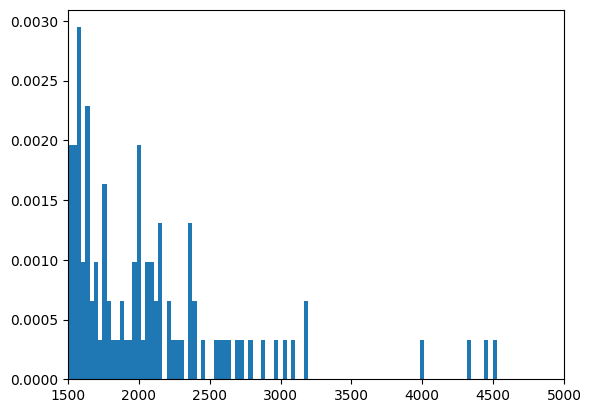

In [814]:
P = [.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9]
loc_gp, scale_gp,shape_gp = 1500, 500,1/10
law_gp = genpareto(loc = loc_gp,scale= scale_gp, c=shape_gp)
mean_gp,std_gp=loc_gp + scale_gp /(1-shape_gp),scale_gp/((1-shape_gp)*np.sqrt(1-2*shape_gp))
Y_gp = law_gp.rvs(101)
#Q_gp = law_gp.ppf(P)
Q_gp = np.quantile(Y_gp,P)
mean_gp,std_gp = np.mean(Y_gp),np.std(Y_gp)
min_gp,max_gp = np.min(Y_gp),np.max(Y_gp)
print("Mean = {:.2E}, std = {:.2E}".format(mean_gp, std_gp))
print("Min = {}, Max = {}".format(min_gp, max_gp))
plt.hist(Y_gp[np.where(Y_gp<5000)],bins=100,density=True);
plt.xlim(1500,5000)

Mean = 2.23E+03, std = 1.07E+03
Min = 1519.146448482829, Max = 6898.756601686518


(1500.0, 5000.0)

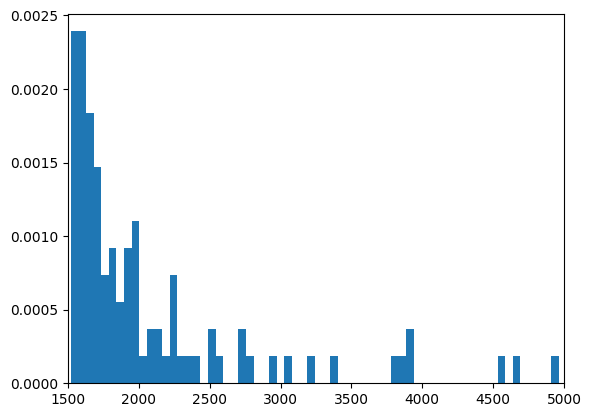

In [815]:
loc_ln, scale_ln, shape_ln = 1500, 5.8, 1.19

law_ln = lognorm(loc=loc_ln, scale=np.exp(scale_ln), s=shape_ln)
mean_ln = np.exp(scale_ln + shape_ln**2/2) + loc_ln
std_ln = np.sqrt(np.exp(shape_ln**2) - 1) * np.exp(scale_ln + shape_ln**2/2)

Y_ln = law_ln.rvs(101)
#Q_ln = law_ln.ppf(P)
Q_ln=np.quantile(Y_ln,P)
mean_ln,std_ln = np.mean(Y_ln),np.std(Y_ln)
min_ln,max_ln = np.min(Y_ln),np.max(Y_ln)
print("Mean = {:.2E}, std = {:.2E}".format(mean_ln, std_ln))
print("Min = {}, Max = {}".format(min_ln, max_ln))

plt.hist(Y_ln[np.where(Y_gp<5000)],bins=100,density=True);
plt.xlim(1500,5000)

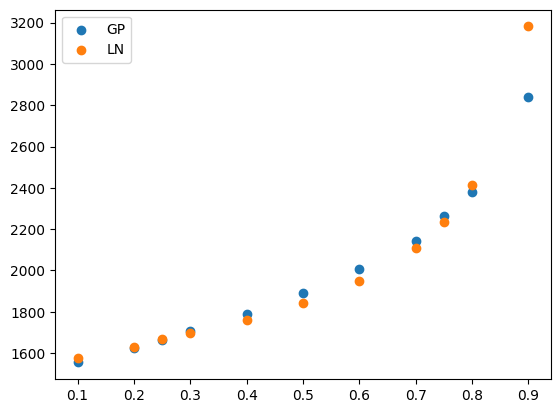

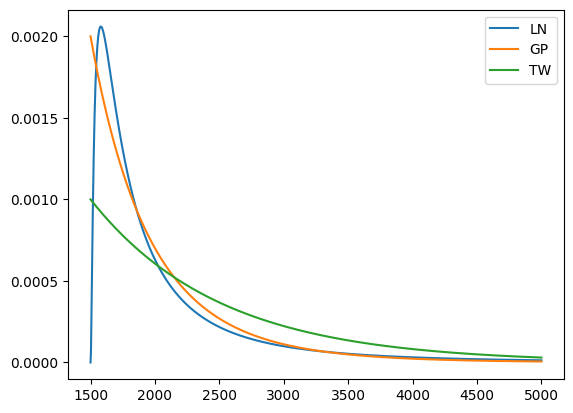

In [569]:
plt.scatter(P,Q_gp,label="GP")
plt.scatter(P,Q_ln,label="LN")
plt.legend()
plt.show()
law_tw = weibull_min(c=1, scale=1000, loc=1500)
x = np.linspace(1500,5000,1000)
plt.plot(x,law_ln.pdf(x),label="LN")
plt.plot(x,law_gp.pdf(x),label="GP")
plt.plot(x,law_tw.pdf(x),label="TW")
plt.legend()
plt.show()

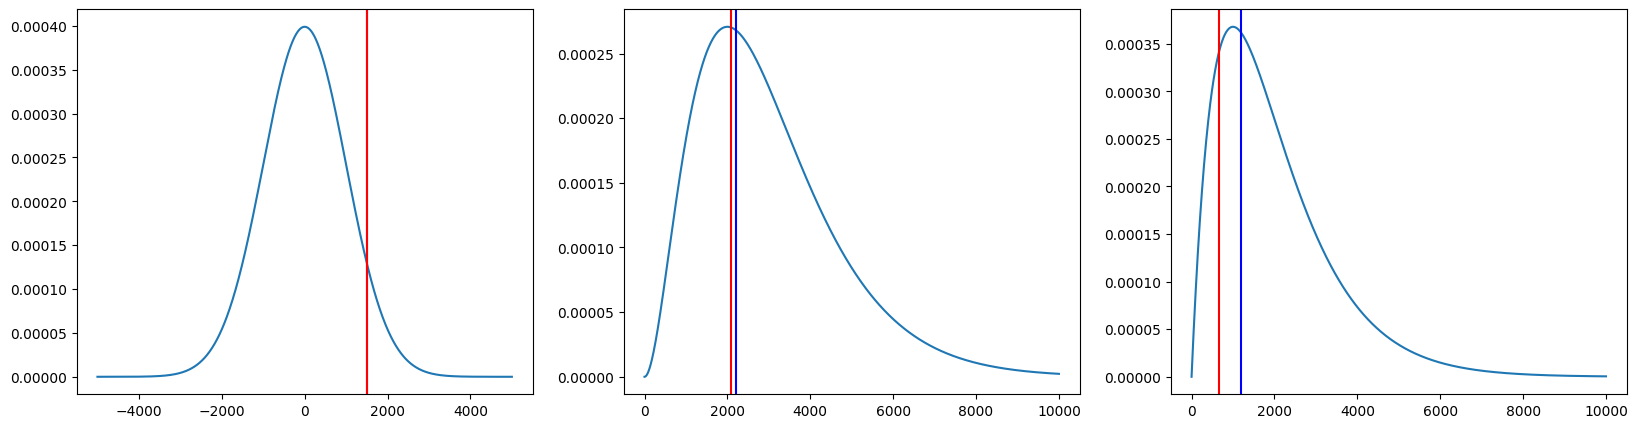

In [539]:
f,ax = plt.subplots(1,3,figsize=(20,5))

x=np.linspace(-5000,5000,1000)
ax[0].plot(x,norm.pdf(x,loc=0,scale=1000))
ax[0].axvline(loc_ln,color="blue")
ax[0].axvline(loc_gp,color="red")

x=np.linspace(0,10000,1000)
ax[1].plot(x,gamma.pdf(x,a=3,scale=1000))
ax[1].axvline(mean_ln,color="blue")
ax[1].axvline(mean_gp,color="red")

x=np.linspace(0,10000,1000)
ax[2].plot(x,gamma.pdf(x,a=2,scale=1000))
ax[2].axvline(std_ln,color="blue")
ax[2].axvline(std_gp,color="red")

# Log-Normal

## True

In [820]:
T=100000
Gibbs_ln_ln= Gibbs_Quantile(T,101,Q_ln,P,"translated_lognormal",
                             prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=10,
                             prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=50,
                             prior_shape= "gamma",par_prior_shape=[2,1000],std_prop_shape=50,
                             std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True,List_X=True)
                            #prior_loc="normal",par_prior_loc=[0,1000],std_prop_loc=15,
                             #prior_scale = "normal",par_prior_scale=[0,1000],std_prop_scale=60,


Init...
Avant reparametrization 1521.6761808805659 7.504401434201737 1
Apres reparametrization 1521.6761808805659 4515.7835752577885 3924.7732643690492
In Quantile_init : init_theta = [1521.6761808805659, 4515.7835752577885, 3924.7732643690492]
A supprimere : Init_theta = [1521.6761808805659, 4515.7835752577885, 3924.7732643690492] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [05:57<00:00, 280.08it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 41.98% scale = 77.73% shape = 95.04% 


In [816]:
true_ln_ln=Gibbs_Quantile(100000,101,Q_gp,P,"translated_lognormal",
                             prior_loc = "gamma",par_prior_loc=[10,1000],std_prop_loc=10,
                             prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=50,
                             prior_shape = "gamma",par_prior_shape=[2,1000],std_prop_shape=50,
                             std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True,True_X=Y_ln)

Init...
Avant reparametrization 1518.3321186251226 7.581448620038393 1
Apres reparametrization 1518.3321186251226 4752.246677154752 4239.120287537634
In Quantile_init : init_theta = [1518.3321186251226, 4752.246677154752, 4239.120287537634]
A supprimere : Init_theta = [1518.3321186251226, 4752.246677154752, 4239.120287537634] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [04:57<00:00, 336.17it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 47.22% scale = 73.85% shape = 93.25% 


In [ ]:
import seaborn as sns

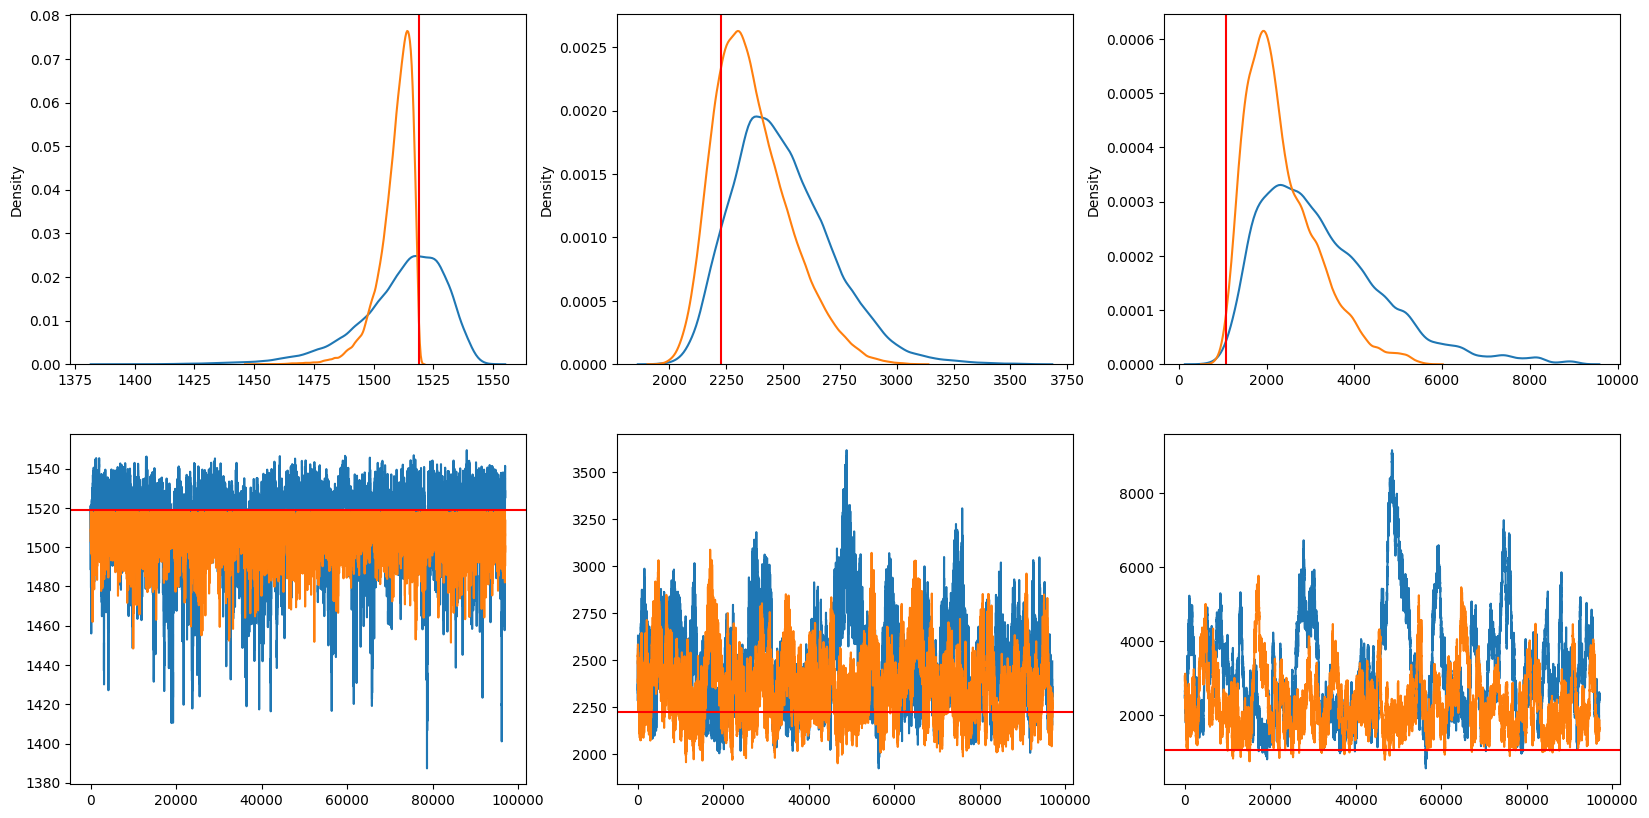

In [827]:
burnin = 3000
display([Gibbs_ln_ln,true_ln_ln],burnin,[min_ln,mean_ln,std_ln])

## False

In [821]:
Gibbs_ln_gp = Gibbs_Quantile(100000,101,Q_ln,P,"generalized_pareto",
                             prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=1,
                             prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=100,
                             prior_shape= "gamma",par_prior_shape=[2,1000],std_prop_shape=1000,
                             std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True,List_X=True)

Init...
Avant reparametrization 1556.8264564811152 899.0714356050045 0.1
Après reparametrization 1556.8264564811152 2555.7947182644534 1116.8804703561748
In Quantile_init : init_theta = [1556.8264564811152, 2555.7947182644534, 1116.8804703561748]
A supprimere : Init_theta = [1556.8264564811152, 2555.7947182644534, 1116.8804703561748] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [06:27<00:00, 258.34it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 82.44% scale = 68.64% shape = 71.36% 


In [826]:
true_ln_gp=Gibbs_Quantile(100000,101,Q_gp,P,"generalized_pareto",
                            prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=1,
                            prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=100,
                            prior_shape= "gamma",par_prior_shape=[2,1000],std_prop_shape=1000,
                            std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True,True_X=Y_ln)

Init...
Avant reparametrization 1552.6622842352685 492.4771392755469 0.1
Après reparametrization 1552.6622842352685 2099.859105652543 611.7846448804191
In Quantile_init : init_theta = [1552.6622842352685, 2099.859105652543, 611.7846448804191]
A supprimere : Init_theta = [1552.6622842352685, 2099.859105652543, 611.7846448804191] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [05:19<00:00, 313.39it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 82.05% scale = 67.39% shape = 69.77% 


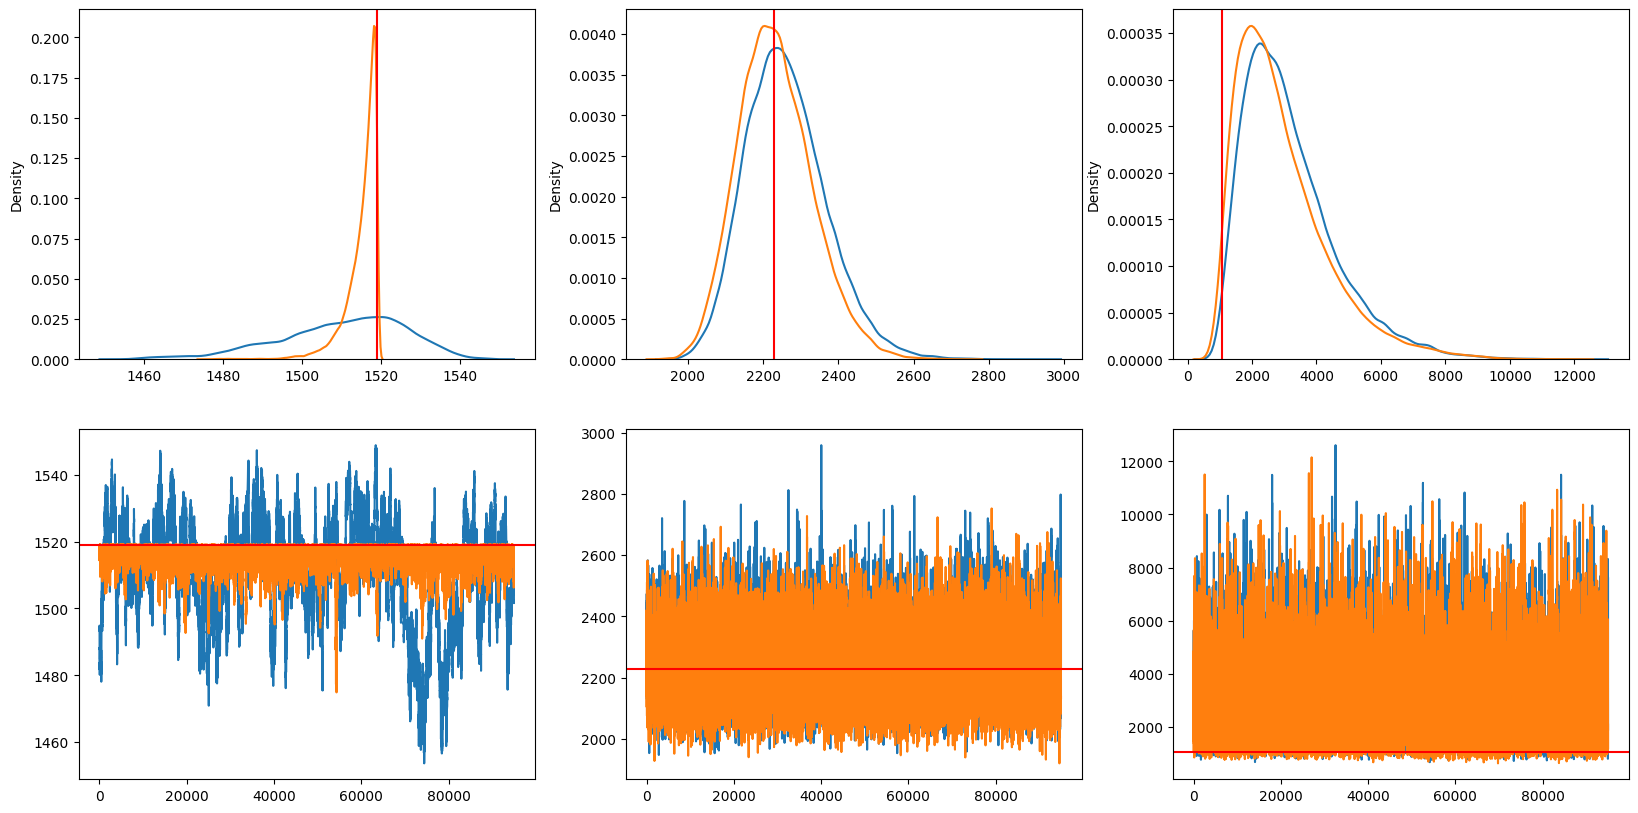

In [828]:
display([Gibbs_ln_gp,true_ln_gp],5000,[min_ln,mean_ln,std_ln])

## Comparison

True LN par : loc = 1500, scale = 5.8, shape = 1.19
Sim LN par : loc = 1503.0953646240657, scale = 5.83903708251482, shape = 1.2067663148831482
Sim GP par : loc = 1535.4493205195026, scale = 159.49958161886968, shape = 1.7235370267638215
True sim GP par : loc = 1497.5067132328545, scale = 5.868466975983758, shape = 1.1789682112569186
True sim LN par : loc = 1505.8243175886423, scale = 289.0794985443216, shape = 1.3513019345353736


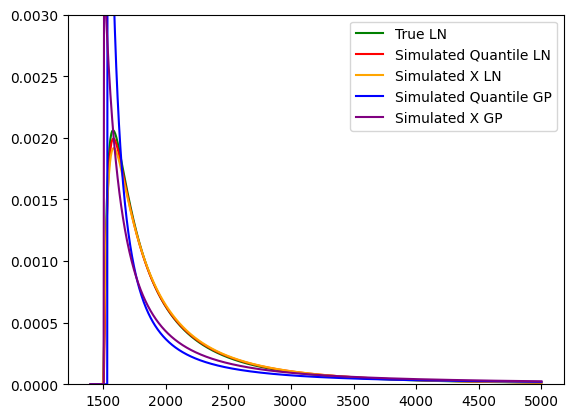

In [744]:
burnin = 10000
post_loc_ln_ln = np.mean(Gibbs_ln_ln["chains"]["loc"][burnin:])
post_mean_ln_ln = np.mean(Gibbs_ln_ln["chains"]["scale"][burnin:])
post_std_ln_ln = np.mean(Gibbs_ln_ln["chains"]["shape"][burnin:])
post_scale_ln_ln = np.log((post_mean_ln_ln - post_loc_ln_ln)**2/np.sqrt((post_mean_ln_ln - post_loc_ln_ln)**2+post_std_ln_ln**2))
post_shape_ln_ln = np.sqrt(np.log(1+post_std_ln_ln**2/(post_mean_ln_ln - post_loc_ln_ln)**2))

true_loc_ln_ln = np.mean(true_ln_ln["chains"]["loc"][burnin:])
true_mean_ln_ln = np.mean(true_ln_ln["chains"]["scale"][burnin:])
true_std_ln_ln = np.mean(true_ln_ln["chains"]["shape"][burnin:])
true_scale_ln_ln = np.log((true_mean_ln_ln - true_loc_ln_ln)**2/np.sqrt((true_mean_ln_ln - true_loc_ln_ln)**2+true_std_ln_ln**2))
true_shape_ln_ln = np.sqrt(np.log(1+true_std_ln_ln**2/(true_mean_ln_ln - true_loc_ln_ln)**2))

post_loc_ln_gp = np.mean(Gibbs_ln_gp["chains"]["loc"][burnin:])
post_mean_ln_gp = np.mean(Gibbs_ln_gp["chains"]["scale"][burnin:])
post_std_ln_gp = np.mean(Gibbs_ln_gp["chains"]["shape"][burnin:])
post_scale_ln_gp = (post_mean_ln_gp - post_loc_ln_gp)**2/np.sqrt((post_mean_ln_gp - post_loc_ln_gp)**2+post_std_ln_gp**2)
post_shape_ln_gp = np.sqrt(np.log(1+post_std_ln_gp**2/(post_mean_ln_gp - post_loc_ln_gp)**2))

true_loc_ln_gp = np.mean(true_ln_gp["chains"]["loc"][burnin:])
true_mean_ln_gp = np.mean(true_ln_gp["chains"]["scale"][burnin:])
true_std_ln_gp = np.mean(true_ln_gp["chains"]["shape"][burnin:])
true_scale_ln_gp = (true_mean_ln_gp - true_loc_ln_gp)**2/np.sqrt((true_mean_ln_gp - true_loc_ln_gp)**2+true_std_ln_gp**2)
true_shape_ln_gp = np.sqrt(np.log(1+true_std_ln_gp**2/(true_mean_ln_gp - true_loc_ln_gp)**2))


print("True LN par : loc = {}, scale = {}, shape = {}".format(loc_ln,scale_ln,shape_ln))
print("Sim LN par : loc = {}, scale = {}, shape = {}".format(post_loc_ln_ln,post_scale_ln_ln,post_shape_ln_ln))
print("Sim GP par : loc = {}, scale = {}, shape = {}".format(post_loc_ln_gp,post_scale_ln_gp,post_shape_ln_gp))
print("True sim GP par : loc = {}, scale = {}, shape = {}".format(true_loc_ln_ln,true_scale_ln_ln,true_shape_ln_ln))
print("True sim LN par : loc = {}, scale = {}, shape = {}".format(true_loc_ln_gp,true_scale_ln_gp,true_shape_ln_gp))
x=np.linspace(1400,5000,1000)
plt.plot(x,lognorm(s=shape_ln, scale=np.exp(scale_ln),loc=loc_ln).pdf(x),label="True LN",color="green")
plt.plot(x,lognorm(s = post_shape_ln_ln,scale = np.exp(post_scale_ln_ln),loc=post_loc_ln_ln).pdf(x),label="Simulated Quantile LN",color="red")
plt.plot(x, lognorm(s=true_shape_ln_ln, scale=np.exp(true_scale_ln_ln),loc=true_loc_ln_ln).pdf(x),label="Simulated X LN",color="orange")
plt.plot(x,genpareto(loc=post_loc_ln_gp,scale=post_scale_ln_gp,c=post_shape_ln_gp).pdf(x),label="Simulated Quantile GP",color="blue")
plt.plot(x,genpareto(loc=true_loc_ln_gp,scale=true_scale_ln_gp,c=true_shape_ln_gp).pdf(x),label="Simulated X GP",color="purple")
plt.ylim(0,.003)
plt.legend()

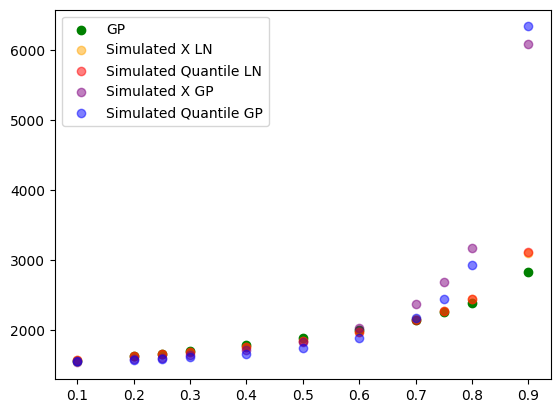

In [749]:
plt.scatter(P,Q_gp,label="GP",color="green")
plt.scatter(P,lognorm(s=true_shape_ln_ln, scale=np.exp(true_scale_ln_ln),loc=true_loc_ln_ln).ppf(P),label="Simulated X LN",color="orange",alpha=.5)
plt.scatter(P,lognorm(s = post_shape_ln_ln,scale = np.exp(post_scale_ln_ln),loc=post_loc_ln_ln).ppf(P),label="Simulated Quantile LN",color="red",alpha=.5)
plt.scatter(P,genpareto(loc=true_loc_ln_gp,scale=true_scale_ln_gp,c=true_shape_ln_gp).ppf(P),label="Simulated X GP",color="purple",alpha=.5)
plt.scatter(P,genpareto(loc=post_loc_ln_gp,scale=post_scale_ln_gp,c=post_shape_ln_gp).ppf(P),label="Simulated Quantile GP",color="blue",alpha=.5)
plt.legend()

# Gen-Pareto

## True

In [822]:
Gibbs_gp_gp = Gibbs_Quantile(100000,101,Q_gp,P,"generalized_pareto",
                             prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=1,
                             prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=70,
                             prior_shape= "gamma",par_prior_shape=[2,1000],std_prop_shape=100,
                             std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True,List_X=True)

Init...
Avant reparametrization 1552.6622842352685 492.4771392755469 0.1
Après reparametrization 1552.6622842352685 2099.859105652543 611.7846448804191
In Quantile_init : init_theta = [1552.6622842352685, 2099.859105652543, 611.7846448804191]
A supprimere : Init_theta = [1552.6622842352685, 2099.859105652543, 611.7846448804191] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [06:33<00:00, 253.97it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 84.06% scale = 70.31% shape = 88.23% 


In [823]:
true_gp_gp = Gibbs_Quantile(100000,101,Q_gp,P,"generalized_pareto",
                             prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=1,
                             prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=70,
                             prior_shape= "gamma",par_prior_shape=[2,1000],std_prop_shape=100,
                             std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True,True_X=Y_gp)

Init...
Avant reparametrization 1552.6622842352685 492.4771392755469 0.1
Après reparametrization 1552.6622842352685 2099.859105652543 611.7846448804191
In Quantile_init : init_theta = [1552.6622842352685, 2099.859105652543, 611.7846448804191]
A supprimere : Init_theta = [1552.6622842352685, 2099.859105652543, 611.7846448804191] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [05:17<00:00, 315.23it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 84.83% scale = 66.70% shape = 83.16% 


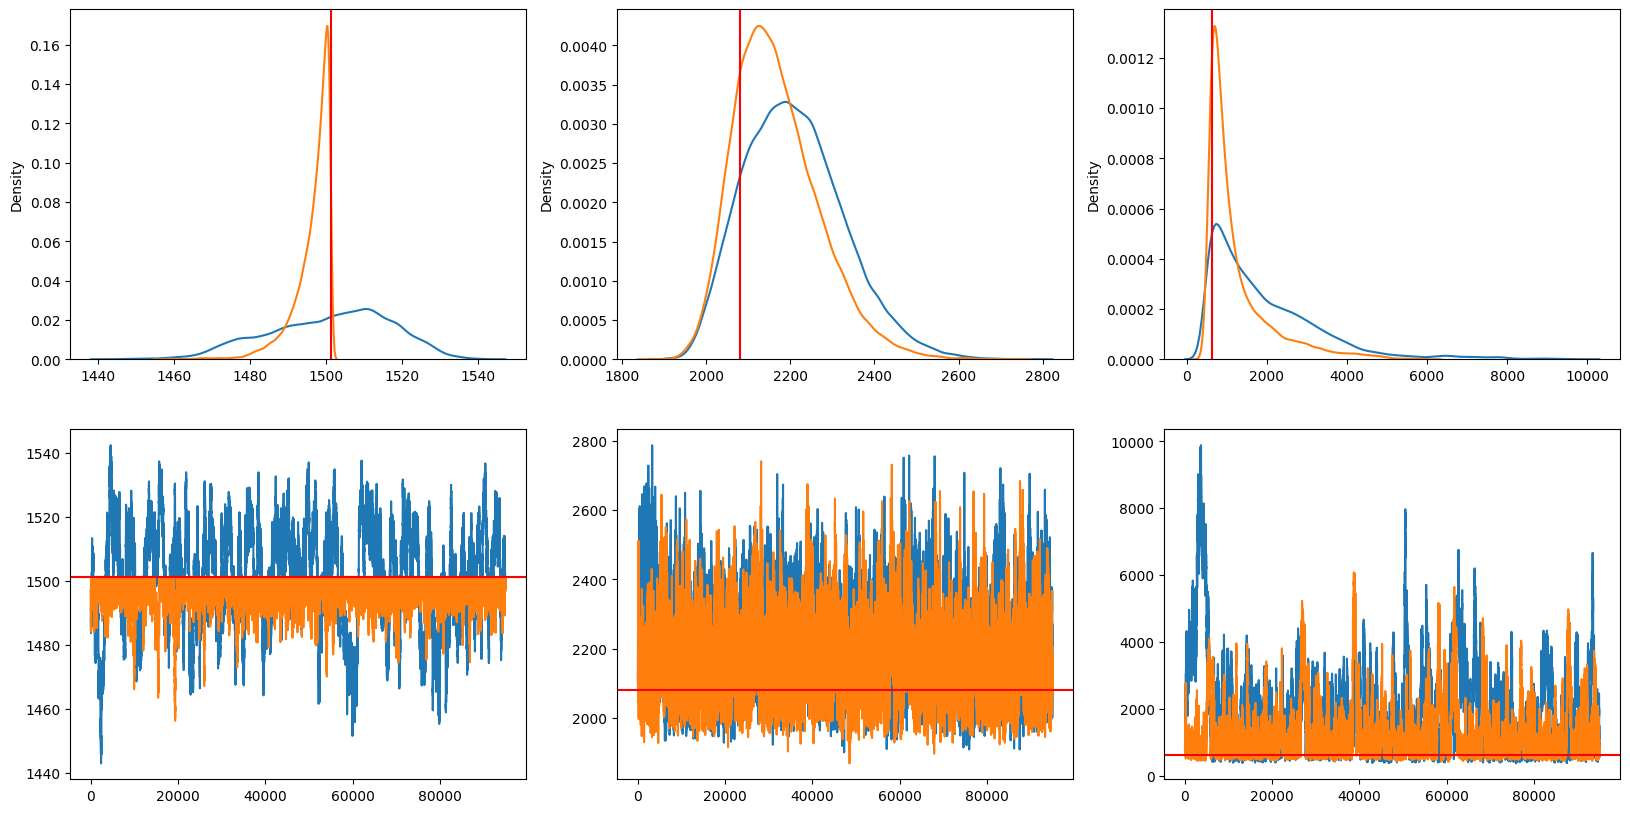

In [830]:
display([Gibbs_gp_gp,true_gp_gp],5000,[min_gp,mean_gp,std_gp])

## False 

In [824]:
Gibbs_gp_ln = Gibbs_Quantile(100000,101,Q_gp,P,"translated_lognormal",
                             prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=12,
                             prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=50,
                             prior_shape= "gamma",par_prior_shape=[2,1000],std_prop_shape=50,
                             std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True, List_X=True)

Init...
Avant reparametrization 1518.3321186251226 7.581448620038393 1
Apres reparametrization 1518.3321186251226 4752.246677154752 4239.120287537634
In Quantile_init : init_theta = [1518.3321186251226, 4752.246677154752, 4239.120287537634]
A supprimere : Init_theta = [1518.3321186251226, 4752.246677154752, 4239.120287537634] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [06:23<00:00, 260.44it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 67.64% scale = 66.98% shape = 85.04% 


In [825]:
true_gp_ln = Gibbs_Quantile(100000,101,Q_gp,P,"translated_lognormal",
                             prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=12,
                             prior_scale = "gamma",par_prior_scale=[3,1000],std_prop_scale=50,
                             prior_shape= "gamma",par_prior_shape=[2,1000],std_prop_shape=50,
                             std_prop_quantile=.05,verbose=True,epsilon=1,reparametrization=True,True_X=Y_gp)

Init...
Avant reparametrization 1518.3321186251226 7.581448620038393 1
Apres reparametrization 1518.3321186251226 4752.246677154752 4239.120287537634
In Quantile_init : init_theta = [1518.3321186251226, 4752.246677154752, 4239.120287537634]
A supprimere : Init_theta = [1518.3321186251226, 4752.246677154752, 4239.120287537634] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.]


100%|██████████| 100000/100000 [05:18<00:00, 313.69it/s]


I= [11. 21. 26. 31. 41. 51. 61. 71. 76. 81. 91.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 65.70% scale = 65.30% shape = 85.83% 


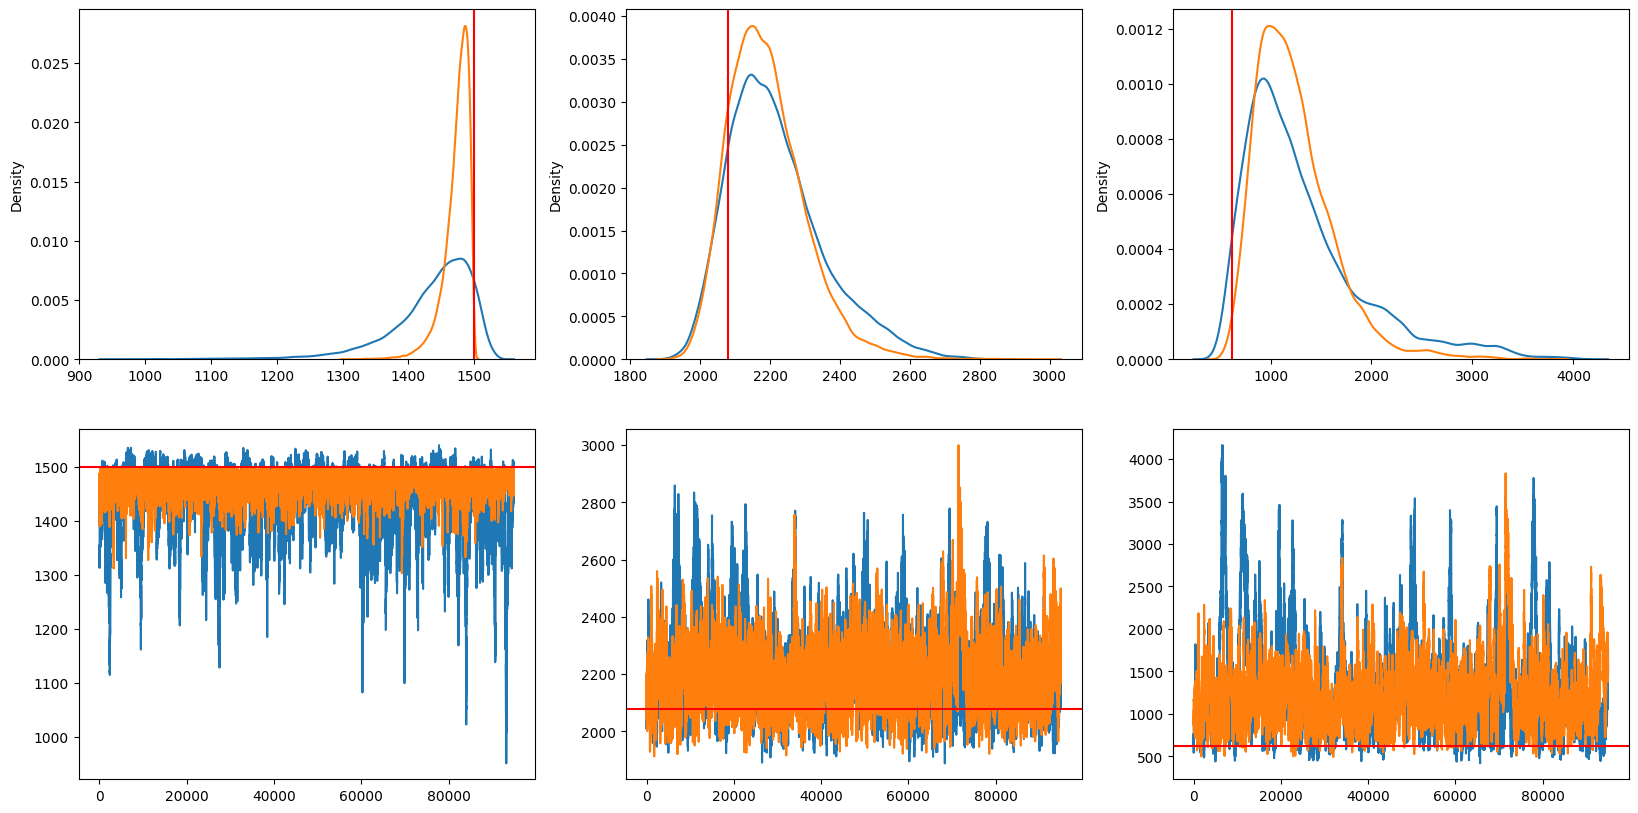

In [831]:
display([Gibbs_gp_ln,true_gp_ln],5000,[loc_gp,mean_gp,std_gp])

In [597]:
Gibbs_gp_gp["chains"]

{'loc': array([1553.65612301, 1553.65612301, 1553.65612301, ..., 1506.39785302,
        1506.85181733, 1506.85181733]),
 'scale': array([2127.66756181, 2130.78765655, 2094.28762395, ..., 2064.28760052,
        2064.28760052, 2094.99718362]),
 'shape': array([641.76429851, 641.76429851, 681.13872523, ..., 560.81503461,
        594.5516064 , 594.5516064 ])}

In [607]:
print(loc_gp,mean_gp,std_gp)
burnin=10000
loc_sim_gp_gp, mean_sim_gp_gp, std_sim_gp_gp = np.mean(Gibbs_gp_gp["chains"]["loc"][burnin:]),np.mean(Gibbs_gp_gp["chains"]["scale"][burnin:]),np.mean(Gibbs_gp_gp["chains"]["shape"][burnin:])
print(loc_sim_gp_gp,mean_sim_gp_gp,std_sim_gp_gp)
scale_sim_gp_gp = (mean_sim_gp_gp - loc_sim_gp_gp)/2+(mean_sim_gp_gp - loc_sim_gp_gp)**3/(2*std_sim_gp_gp**2)
shape_sim_gp_gp = 1/2-(mean_sim_gp_gp - loc_sim_gp_gp)**2/(2*std_sim_gp_gp**2)

print(loc_gp,scale_gp,shape_gp)
print(loc_sim_gp_gp,scale_sim_gp_gp,shape_sim_gp_gp)



1500 2084.299770462251 658.8800942277646
1497.5645168259668 2076.886472890064 623.0321995213932
1500 500 0.1
1497.5645168259668 540.1040283193843 0.06769625651884253


## Comparison

True GP par : loc = 1500, scale = 500, shape = 0.1
Sim GP par : loc = 1495.1620764001104, scale = 545.5667630026408, shape = 0.06154616092415671
Sim LN par : loc = 1382.6118089602903, scale = 6.213263887715489, shape = 0.8423642268585879
Sim true GP par : loc = 1500.476740052591, scale = 522.5864286681821, shape = 0.11195848902734712
Sim true LN par : loc = 1465.4654715645522, scale = 5.961089108998269, shape = 1.0227235864239275


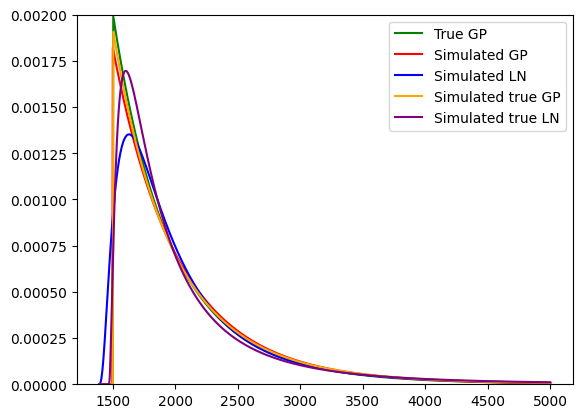

In [747]:
post_loc_gp_gp = np.mean(Gibbs_gp_gp["chains"]["loc"][burnin:])
post_mean_gp_gp = np.mean(Gibbs_gp_gp["chains"]["scale"][burnin:])
post_std_gp_gp = np.mean(Gibbs_gp_gp["chains"]["shape"][burnin:])
post_scale_gp_gp = (post_mean_gp_gp - post_loc_gp_gp)/2+(post_mean_gp_gp - post_loc_gp_gp)**3/(2*post_std_gp_gp**2)
post_shape_gp_gp = 1/2-(post_mean_gp_gp - post_loc_gp_gp)**2/(2*post_std_gp_gp**2)


true_loc_gp_gp = np.mean(true_gp_gp["chains"]["loc"][burnin:])
true_mean_gp_gp = np.mean(true_gp_gp["chains"]["scale"][burnin:])
true_std_gp_gp = np.mean(true_gp_gp["chains"]["shape"][burnin:])
true_scale_gp_gp = (true_mean_gp_gp - true_loc_gp_gp)/2+(true_mean_gp_gp - true_loc_gp_gp)**3/(2*true_std_gp_gp**2)
true_shape_gp_gp = 1/2-(true_mean_gp_gp - true_loc_gp_gp)**2/(2*true_std_gp_gp**2)


post_loc_gp_ln = np.mean(Gibbs_gp_ln["chains"]["loc"][burnin:])
post_mean_gp_ln = np.mean(Gibbs_gp_ln["chains"]["scale"][burnin:])
post_std_gp_ln = np.mean(Gibbs_gp_ln["chains"]["shape"][burnin:])
post_scale_gp_ln = np.log((post_mean_gp_ln - post_loc_gp_ln)**2/np.sqrt((post_mean_gp_ln - post_loc_gp_ln)**2+post_std_gp_ln**2))
post_shape_gp_ln = np.sqrt(np.log(1+post_std_gp_ln**2/(post_mean_gp_ln - post_loc_gp_ln)**2))

true_loc_gp_ln = np.mean(true_gp_ln["chains"]["loc"][burnin:])
true_mean_gp_ln = np.mean(true_gp_ln["chains"]["scale"][burnin:])
true_std_gp_ln = np.mean(true_gp_ln["chains"]["shape"][burnin:])
true_scale_gp_ln = np.log((true_mean_gp_ln - true_loc_gp_ln)**2/np.sqrt((true_mean_gp_ln - true_loc_gp_ln)**2+true_std_gp_ln**2))
true_shape_gp_ln = np.sqrt(np.log(1+true_std_gp_ln**2/(true_mean_gp_ln - true_loc_gp_ln)**2))

print("True GP par : loc = {}, scale = {}, shape = {}".format(loc_gp,scale_gp,shape_gp))
print("Sim GP par : loc = {}, scale = {}, shape = {}".format(post_loc_gp_gp,post_scale_gp_gp,post_shape_gp_gp))
print("Sim LN par : loc = {}, scale = {}, shape = {}".format(post_loc_gp_ln,post_scale_gp_ln,post_shape_gp_ln))
print("Sim true GP par : loc = {}, scale = {}, shape = {}".format(true_loc_gp_gp,true_scale_gp_gp,true_shape_gp_gp))
print("Sim true LN par : loc = {}, scale = {}, shape = {}".format(true_loc_gp_ln,true_scale_gp_ln,true_shape_gp_ln))

x=np.linspace(1390,5000,1000)
plt.plot(x,genpareto(c=shape_gp, loc=loc_gp, scale=scale_gp).pdf(x),label="True GP",color="green")
plt.plot(x,genpareto(c=post_shape_gp_gp, loc=post_loc_gp_gp, scale=post_scale_gp_gp).pdf(x),label="Simulated GP",color="red")
plt.plot(x,lognorm(s=post_shape_gp_ln, scale=np.exp(post_scale_gp_ln),loc=post_loc_gp_ln).pdf(x),label="Simulated LN",color="blue")
plt.plot(x,genpareto(c=true_shape_gp_gp, loc=true_loc_gp_gp, scale=true_scale_gp_gp).pdf(x),label="Simulated true GP",color="orange")
plt.plot(x,lognorm(s=true_shape_gp_ln, scale=np.exp(true_scale_gp_ln),loc=true_loc_gp_ln).pdf(x),label="Simulated true LN",color="purple")
plt.ylim(0,.002)
plt.legend()

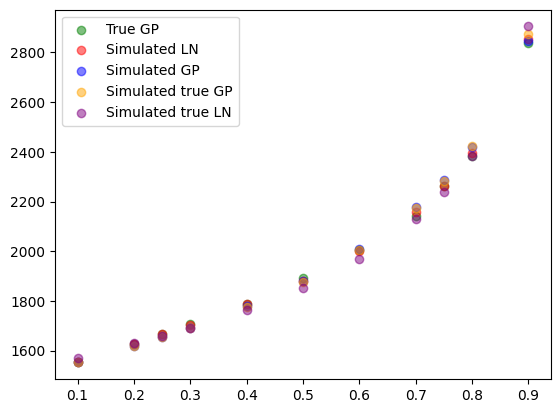

In [750]:
plt.scatter(P,(Q_gp),color="green",label="True GP",alpha=.5)
plt.scatter(P,(lognorm(s=post_shape_gp_ln, scale=np.exp(post_scale_gp_ln),loc=post_loc_gp_ln).ppf(P)),color="red",label="Simulated LN",alpha=.5)
plt.scatter(P,(genpareto(loc=post_loc_gp_gp, scale=post_scale_gp_gp, c=post_shape_gp_gp).ppf(P)),color="blue",label="Simulated GP",alpha=.5)
plt.scatter(P,(genpareto(loc=true_loc_gp_gp, scale=true_scale_gp_gp, c=true_shape_gp_gp).ppf(P)),color="orange",label="Simulated true GP",alpha=.5)
plt.scatter(P,(lognorm(s=true_shape_gp_ln, scale=np.exp(true_scale_gp_ln),loc=true_loc_gp_ln).ppf(P)),color="purple",label="Simulated true LN",alpha=.5)

plt.legend()

# Global comparison


## Bridge Calculation

In [658]:
def Bridge(y,post1,post2,like1,like2,prior1,prior2,BF_init=1,epsilon=.01,n=100):
    BF = [0,BF_init]
    k = 0
    
    while np.abs(BF[-1]-BF[-2])>epsilon and (k+1)*n<post1.shape[0]:
        theta1=post1[k*n:(k+1)*n]
        theta2=post2[k*n:(k+1)*n]
        p12= np.array([like1(y,theta1[i])*prior1(theta2[i]) for i in range(n)])
        p22 = np.array([like2(y,theta2[i])*prior2(theta2[i]) for i in range(n)])
        p21 = np.array([like2(y,theta1[i])*prior2(theta1[i]) for i in range(n)])
        p11 = np.array([like1(y,theta1[i])*prior1(theta1[i]) for i in range(n)])
        numerator = np.sum(p12/(p12+p22*BF[-1]))
        denominator = np.sum(p21/(p21+p11*BF[-1]))
        new_BF = numerator/denominator
        print("Denominator = {:.2E} Numerator = {:.2E} BF = {}".format(denominator, numerator, new_BF))
        BF.append(new_BF)
        
    return BF

In [870]:
def BF_Bridge_X(y,theta1,theta2,llike1,llike2,BF_init=1,epsilon=.001,n=100):
    BF = [0,BF_init]
    k=0
    while np.abs(BF[-1]-BF[-2])>epsilon and (k+1)*n<theta1.shape[0]:
            
        numerator = np.sum([1/(1+np.exp(llike2(y,theta2[i])-llike1(y,theta2[i]))*BF[-1]) for i in range(k*n,(k+1)*n)])
        denominator = np.sum([1/(np.exp(llike1(y,theta1[i])-llike2(y,theta1[i]))+BF[-1]) for i in range(k*n,(k+1)*n)])
        new_BF = numerator/denominator
        print("{}. Numerator = {:.2E} Denominator = {:.2E} BF = {}".format(k+1,numerator, denominator, new_BF))
        BF.append(new_BF)
        k+=1
    return BF[1:]

In [878]:
def BF_Bridge_Quantile(y1,y2,theta1,theta2,llike1,llike2,BF_init=1,epsilon=.001,n=100):
    BF = [0,BF_init]
    if np.ndim(y1)==1:
        y1= np.repeat(y1,theta1.shape[0]).reshape(-1,theta1.shape[0]).T
    if np.ndim(y2)==1:
        y2= np.repeat(y2,theta2.shape[0]).reshape(-1,theta2.shape[0]).T
    k=0
    while np.abs(BF[-1]-BF[-2])>epsilon and (k+1)*n<theta1.shape[0]:
            
        numerator = np.sum([1/(1+np.exp(llike2(y2[i],theta2[i])-llike1(y2[i],theta2[i]))*BF[-1]) for i in range(k*n,(k+1)*n)])
        denominator = np.sum([1/(np.exp(llike1(y1[i],theta1[i])-llike2(y1[i],theta1[i]))+BF[-1]) for i in range(k*n,(k+1)*n)])
        new_BF = numerator/denominator
        print("{}. Numerator = {:.2E} Denominator = {:.2E} BF = {}".format(k+1,numerator, denominator, new_BF))
        BF.append(new_BF)
        k+=1
    return BF[1:]

In [858]:
np.repeat([[1,2]],2).reshape(2,-1)

array([[1, 1],
       [2, 2]])

In [862]:
Y_ln

array([3368.68857203, 1624.43871028, 2361.93241772, 1847.04466574,
       1705.09891021, 2510.0302321 , 2255.72140108, 6898.75660169,
       1723.17271833, 2920.26526316, 1816.01793316, 1670.51396104,
       1661.53847717, 1599.91646342, 5329.17000295, 1634.36595631,
       1726.72959681, 1708.13435495, 1574.90285813, 1573.21806645,
       1649.81381118, 1667.45793387, 1853.62269067, 2503.7692575 ,
       1519.14644848, 1719.25146679, 1579.93013342, 1894.22739796,
       1899.86108819, 1624.74885932, 1648.57850059, 1775.05674803,
       2002.33955994, 1678.33627926, 4537.7768663 , 1779.0752036 ,
       1813.47971701, 1622.41153834, 1899.13869015, 1525.27205902,
       1692.5530106 , 3880.76173227, 1985.44199942, 1584.91602853,
       3907.9806817 , 1530.9917434 , 2127.94967687, 1658.61216522,
       1942.49766147, 1793.16931746, 4949.99318571, 5193.52556216,
       2173.04166462, 2321.06473122, 2070.42906521, 3202.41087734,
       1594.62486622, 1572.97100943, 1593.97673208, 2226.71892

In [684]:
def lprior(theta):
    par = [0,1000,3,1000,2,1000]
    return gamma(a=par[0],scale=par[1]).logpdf(theta[0])+gamma(a=par[2],scale=par[3]).logpdf(theta[1])+gamma(a=par[4],scale=par[5]).logpdf(theta[2])

In [698]:
def llike_genpareto(y,par):
    loc_gp,mean_gp,std_gp=par
    scale_gp,shape_gp=(mean_gp - loc_gp)/2+(mean_gp - loc_gp)**3/(2*std_gp**2),1/2-(mean_gp - loc_gp)**2/(2*std_gp**2)
    return np.sum(genpareto(loc=loc_gp,scale=scale_gp,c=shape_gp).logpdf(y))

In [697]:
def llike_lognormal(y, par):
    loc_ln, mean_ln, std_ln = par
    scale_ln, shape_ln = np.log((mean_ln - loc_ln)**2/np.sqrt((mean_ln - loc_ln)**2+std_ln**2)),np.sqrt(np.log(1+std_ln**2/(mean_ln - loc_ln)**2))
    return np.sum(lognorm(s=shape_ln, scale=np.exp(scale_ln), loc=loc_ln).logpdf(y))


In [841]:
burnin=5000

post_gp_gp = np.array([Gibbs_gp_gp["chains"]["loc"], Gibbs_gp_gp["chains"]["scale"], Gibbs_gp_gp["chains"]["shape"]]).T[burnin:]
post_gp_ln = np.array([Gibbs_gp_ln["chains"]["loc"], Gibbs_gp_ln["chains"]["scale"], Gibbs_gp_ln["chains"]["shape"]]).T[burnin:]
post_ln_gp = np.array([Gibbs_ln_gp["chains"]["loc"], Gibbs_ln_gp["chains"]["scale"], Gibbs_ln_gp["chains"]["shape"]]).T[burnin:]
post_ln_ln = np.array([Gibbs_ln_ln["chains"]["loc"], Gibbs_ln_ln["chains"]["scale"], Gibbs_ln_ln["chains"]["shape"]]).T[burnin:]

Y_ln_ln = np.array(Gibbs_ln_ln["X"][burnin:])
Y_ln_gp = np.array(Gibbs_ln_gp["X"][burnin:])
Y_gp_ln = np.array(Gibbs_gp_ln["X"][burnin:])
Y_gp_gp = np.array(Gibbs_gp_gp["X"][burnin:])

true_post_gp_gp = np.array([true_gp_gp["chains"]["loc"], true_gp_gp["chains"]["scale"], true_gp_gp["chains"]["shape"]]).T[burnin:]
true_post_gp_ln = np.array([true_gp_ln["chains"]["loc"], true_gp_ln["chains"]["scale"], true_gp_ln["chains"]["shape"]]).T[burnin:]
true_post_ln_gp = np.array([true_ln_gp["chains"]["loc"], true_ln_gp["chains"]["scale"], true_ln_gp["chains"]["shape"]]).T[burnin:]
true_post_ln_ln = np.array([true_ln_ln["chains"]["loc"], true_ln_ln["chains"]["scale"], true_ln_ln["chains"]["shape"]]).T[burnin:]

In [882]:
BF_true_ln_10K = BF_Bridge_X(Y_ln,true_post_ln_ln,true_post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=10000)

1. Numerator = 1.66E+03 Denominator = 1.11E+03 BF = 1.5005619699301915
2. Numerator = 1.66E+03 Denominator = 9.88E+02 BF = 1.6786055649014013
3. Numerator = 1.54E+03 Denominator = 1.06E+03 BF = 1.4473686044557534
4. Numerator = 1.75E+03 Denominator = 9.77E+02 BF = 1.7935592875548205
5. Numerator = 1.43E+03 Denominator = 1.08E+03 BF = 1.3224304312559119
6. Numerator = 1.60E+03 Denominator = 1.05E+03 BF = 1.523386803606448
7. Numerator = 1.46E+03 Denominator = 9.48E+02 BF = 1.542736421939286
8. Numerator = 1.86E+03 Denominator = 1.10E+03 BF = 1.6922047354519574
9. Numerator = 1.59E+03 Denominator = 1.01E+03 BF = 1.5648932721429254


In [883]:
BF_true_ln_1K = BF_Bridge_X(Y_ln,true_post_ln_ln,true_post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=1000)

1. Numerator = 1.61E+02 Denominator = 1.38E+02 BF = 1.1726141873092155
2. Numerator = 2.16E+02 Denominator = 9.26E+01 BF = 2.3356720891763736
3. Numerator = 1.18E+02 Denominator = 3.25E+01 BF = 3.618776999711175
4. Numerator = 9.28E+01 Denominator = 5.50E+01 BF = 1.6873416874047897
5. Numerator = 1.38E+02 Denominator = 9.00E+01 BF = 1.5376161100424146
6. Numerator = 1.66E+02 Denominator = 9.12E+01 BF = 1.8198982605010638
7. Numerator = 1.23E+02 Denominator = 1.11E+02 BF = 1.1055988583404923
8. Numerator = 8.32E+01 Denominator = 1.10E+02 BF = 0.7585590289048333
9. Numerator = 1.84E+02 Denominator = 1.54E+02 BF = 1.1918362478094937
10. Numerator = 1.32E+02 Denominator = 1.21E+02 BF = 1.0966169164902444
11. Numerator = 1.67E+02 Denominator = 1.55E+02 BF = 1.0722064726777152
12. Numerator = 1.45E+02 Denominator = 1.36E+02 BF = 1.06130303232404
13. Numerator = 1.93E+02 Denominator = 1.24E+02 BF = 1.5475489130125302
14. Numerator = 1.55E+02 Denominator = 1.19E+02 BF = 1.3029017982279987
15. 

In [893]:
BF_true_ln_2K = BF_Bridge_X(Y_ln,true_post_ln_ln,true_post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=2000)


1. Numerator = 3.89E+02 Denominator = 2.36E+02 BF = 1.6505728872912995
2. Numerator = 2.77E+02 Denominator = 1.11E+02 BF = 2.484732551151234
3. Numerator = 2.46E+02 Denominator = 1.51E+02 BF = 1.6371718745303294
4. Numerator = 1.94E+02 Denominator = 2.13E+02 BF = 0.9141871711166132
5. Numerator = 3.22E+02 Denominator = 2.78E+02 BF = 1.1593116883184833
6. Numerator = 3.02E+02 Denominator = 2.84E+02 BF = 1.0631767804077688
7. Numerator = 3.71E+02 Denominator = 2.64E+02 BF = 1.4063204409753993
8. Numerator = 3.13E+02 Denominator = 6.67E+01 BF = 4.6983375101922
9. Numerator = 1.92E+02 Denominator = 1.07E+02 BF = 1.789988905022859
10. Numerator = 4.06E+02 Denominator = 2.37E+02 BF = 1.7135541346879142
11. Numerator = 2.82E+02 Denominator = 2.13E+02 BF = 1.3281548761749877
12. Numerator = 3.58E+02 Denominator = 2.34E+02 BF = 1.5306973285830325
13. Numerator = 3.59E+02 Denominator = 2.78E+02 BF = 1.292939562401167
14. Numerator = 3.59E+02 Denominator = 1.76E+02 BF = 2.0461796753544466
15. Num

In [894]:
BF_true_ln_5K = BF_Bridge_X(Y_ln,true_post_ln_ln,true_post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=5000)

1. Numerator = 9.08E+02 Denominator = 4.80E+02 BF = 1.8914552798614197
2. Numerator = 5.60E+02 Denominator = 4.97E+02 BF = 1.1262590515480395
3. Numerator = 8.52E+02 Denominator = 5.76E+02 BF = 1.4780091842109837
4. Numerator = 9.08E+02 Denominator = 4.75E+02 BF = 1.9097404633643766
5. Numerator = 7.12E+02 Denominator = 5.28E+02 BF = 1.3502818873098412
6. Numerator = 8.53E+02 Denominator = 5.48E+02 BF = 1.5553486688673808
7. Numerator = 8.27E+02 Denominator = 4.17E+02 BF = 1.9807869182732438
8. Numerator = 7.98E+02 Denominator = 4.84E+02 BF = 1.6502936543507167
9. Numerator = 7.72E+02 Denominator = 5.18E+02 BF = 1.491703015187718
10. Numerator = 7.45E+02 Denominator = 6.30E+02 BF = 1.1826570418105966
11. Numerator = 9.09E+02 Denominator = 4.79E+02 BF = 1.897635838201904
12. Numerator = 6.18E+02 Denominator = 5.11E+02 BF = 1.209759975177553
13. Numerator = 8.63E+02 Denominator = 3.57E+02 BF = 2.4200987276322437
14. Numerator = 5.35E+02 Denominator = 5.01E+02 BF = 1.0682096516995685
15. 

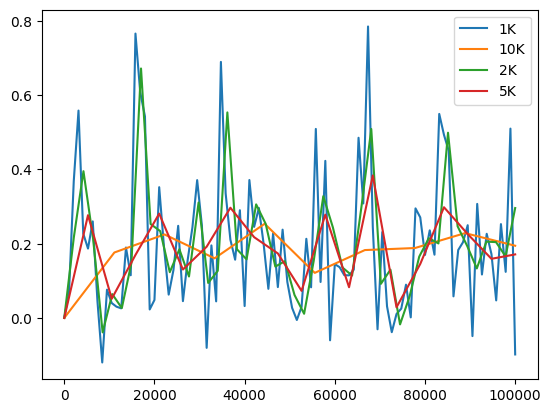

In [895]:
plt.plot(np.linspace(0,100000,len(BF_true_ln_1K)),np.log10(BF_true_ln_1K),label="1K")
plt.plot(np.linspace(0,100000,len(BF_true_ln_10K)),np.log10(BF_true_ln_10K),label="10K")
plt.plot(np.linspace(0,100000,len(BF_true_ln_2K)),np.log10(BF_true_ln_2K),label="2K")
plt.plot(np.linspace(0,100000,len(BF_true_ln_5K)),np.log10(BF_true_ln_5K),label="5K")
plt.legend()

In [880]:
BF_true_gp_10K= BF_Bridge_X(Y_gp,true_post_gp_gp,true_post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=10000)

1. Numerator = 2.25E+03 Denominator = 3.20E+02 BF = 7.019480089263989
2. Numerator = 9.96E+02 Denominator = 1.75E+02 BF = 5.691939124307574
3. Numerator = 1.01E+03 Denominator = 1.47E+02 BF = 6.882827172372804
4. Numerator = 8.55E+02 Denominator = 1.43E+02 BF = 5.984076919622061
5. Numerator = 1.12E+03 Denominator = 1.26E+02 BF = 8.886661514922093
6. Numerator = 8.06E+02 Denominator = 1.17E+02 BF = 6.893237379382803
7. Numerator = 1.05E+03 Denominator = 9.75E+01 BF = 10.817980080209962
8. Numerator = 9.40E+02 Denominator = 8.70E+01 BF = 10.796651640543928
9. Numerator = 6.11E+02 Denominator = 6.71E+01 BF = 9.099819783824342


In [889]:
BF_true_gp_5K= BF_Bridge_X(Y_gp,true_post_gp_gp,true_post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=5000)

1. Numerator = 1.18E+03 Denominator = 1.06E+02 BF = 11.103347257634862
2. Numerator = 2.78E+02 Denominator = 5.35E+01 BF = 5.196284358742797
3. Numerator = 5.88E+02 Denominator = 7.40E+01 BF = 7.9400637587218785
4. Numerator = 4.64E+02 Denominator = 1.03E+02 BF = 4.49919687758488
5. Numerator = 5.86E+02 Denominator = 9.18E+01 BF = 6.384220007059476
6. Numerator = 4.66E+02 Denominator = 6.19E+01 BF = 7.531512025611451
7. Numerator = 4.26E+02 Denominator = 7.04E+01 BF = 6.0455382257362125
8. Numerator = 4.39E+02 Denominator = 7.39E+01 BF = 5.933647046273546
9. Numerator = 5.18E+02 Denominator = 5.53E+01 BF = 9.354584316289298
10. Numerator = 4.61E+02 Denominator = 5.42E+01 BF = 8.515947053084641
11. Numerator = 4.67E+02 Denominator = 6.14E+01 BF = 7.595752349523071
12. Numerator = 3.87E+02 Denominator = 6.23E+01 BF = 6.213922369181767
13. Numerator = 4.83E+02 Denominator = 4.66E+01 BF = 10.354160948935192
14. Numerator = 4.78E+02 Denominator = 4.24E+01 BF = 11.251825034600119
15. Numerat

In [888]:
BF_true_gp_2K= BF_Bridge_X(Y_gp,true_post_gp_gp,true_post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=2000)

1. Numerator = 4.43E+02 Denominator = 4.58E+01 BF = 9.669607157380959
2. Numerator = 1.62E+02 Denominator = 1.43E+01 BF = 11.34967229128941
3. Numerator = 1.11E+02 Denominator = 1.40E+01 BF = 7.936789511336486
4. Numerator = 1.15E+02 Denominator = 1.47E+01 BF = 7.827060031721286
5. Numerator = 1.56E+02 Denominator = 4.47E+01 BF = 3.477380839762832
6. Numerator = 2.92E+02 Denominator = 4.92E+01 BF = 5.931908284732894
7. Numerator = 2.46E+02 Denominator = 1.19E+01 BF = 20.605046430817687
8. Numerator = 8.98E+01 Denominator = 2.38E+01 BF = 3.775734554375096
9. Numerator = 2.72E+02 Denominator = 3.32E+01 BF = 8.211769047735384
10. Numerator = 1.76E+02 Denominator = 4.67E+01 BF = 3.7728496458946967
11. Numerator = 2.90E+02 Denominator = 4.99E+01 BF = 5.807311738378352
12. Numerator = 1.79E+02 Denominator = 1.39E+01 BF = 12.911906939719266
13. Numerator = 1.40E+02 Denominator = 2.47E+01 BF = 5.69145621949524
14. Numerator = 1.94E+02 Denominator = 2.39E+01 BF = 8.094903233639778
15. Numerator

In [881]:
BF_true_gp_1K= BF_Bridge_X(Y_gp,true_post_gp_gp,true_post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=1000)

1. Numerator = 2.16E+02 Denominator = 3.89E+01 BF = 5.559401173554273
2. Numerator = 9.21E+01 Denominator = 3.63E+00 BF = 25.389640923592967
3. Numerator = 5.14E+01 Denominator = 3.91E+00 BF = 13.138495474615926
4. Numerator = 5.51E+01 Denominator = 6.15E+00 BF = 8.95348902266552
5. Numerator = 5.85E+01 Denominator = 8.79E+00 BF = 6.661124112883998
6. Numerator = 8.65E+01 Denominator = 8.02E+00 BF = 10.789202126962183
7. Numerator = 5.67E+01 Denominator = 9.89E+00 BF = 5.740051235024787
8. Numerator = 5.68E+01 Denominator = 3.86E+00 BF = 14.730584479057967
9. Numerator = 5.78E+01 Denominator = 8.13E+00 BF = 7.106065831019363
10. Numerator = 6.82E+01 Denominator = 3.51E+01 BF = 1.9420639130551156
11. Numerator = 2.16E+02 Denominator = 3.55E+01 BF = 6.0817946128188405
12. Numerator = 9.89E+01 Denominator = 1.74E+01 BF = 5.666833178858701
13. Numerator = 1.07E+02 Denominator = 3.15E+00 BF = 33.960280218118506
14. Numerator = 4.62E+01 Denominator = 3.34E+00 BF = 13.830040260824177
15. Nume

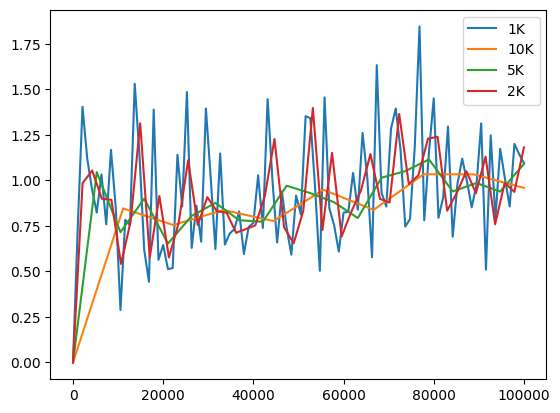

In [892]:
plt.plot(np.linspace(0,100000,len(BF_true_gp_1K)),np.log10(BF_true_gp_1K),label="1K")
plt.plot(np.linspace(0,100000,len(BF_true_gp_10K)),np.log10(BF_true_gp_10K),label="10K")
plt.plot(np.linspace(0,100000,len(BF_true_gp_5K)),np.log10(BF_true_gp_5K),label="5K")
plt.plot(np.linspace(0,100000,len(BF_true_gp_2K)),np.log10(BF_true_gp_2K),label="2K")
plt.legend()

In [896]:
BF_Q_ln_1K = BF_Bridge_Quantile(Y_ln_ln,Y_ln_gp,post_ln_ln,post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=1000)
BF_Q_ln_2K = BF_Bridge_Quantile(Y_ln_ln,Y_ln_gp,post_ln_ln,post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=2000)
BF_Q_ln_5K = BF_Bridge_Quantile(Y_ln_ln,Y_ln_gp,post_ln_ln,post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=5000)
BF_Q_ln_10K = BF_Bridge_Quantile(Y_ln_ln,Y_ln_gp,post_ln_ln,post_ln_gp,llike_lognormal,llike_genpareto,BF_init=1,epsilon=.001,n=10000)

[[1423.48330338 1550.83614418 1489.591032   ... 2248.25659547
  2503.7692575  3790.52346385]
 [1427.18079124 1511.18810203 1499.61997499 ... 2248.25659547
  2503.7692575  3790.52346385]
 [1431.85086809 1545.34658554 1519.82671445 ... 2248.25659547
  2503.7692575  3790.52346385]
 ...
 [1557.82392614 1548.87008752 1534.33344056 ... 2248.25659547
  2503.7692575  3790.52346385]
 [1557.82582533 1554.48045044 1548.04283808 ... 2248.25659547
  2503.7692575  3790.52346385]
 [1557.82587267 1556.20614403 1523.23366303 ... 2248.25659547
  2503.7692575  3790.52346385]]
1. Numerator = 1.90E+02 Denominator = 5.47E+01 BF = 3.4691869300751192
2. Numerator = 1.21E+02 Denominator = 5.98E+01 BF = 2.0275262414753987
3. Numerator = 1.33E+02 Denominator = 3.85E+01 BF = 3.4566230502248403
4. Numerator = 1.35E+02 Denominator = 1.03E+01 BF = 13.123085018589029
5. Numerator = 5.74E+01 Denominator = 8.19E+00 BF = 7.006925679194089
6. Numerator = 7.61E+01 Denominator = 1.17E+01 BF = 6.531021688098608
7. Numerator

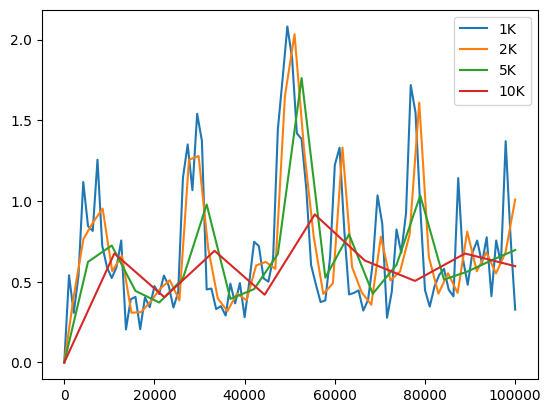

In [897]:
plt.plot(np.linspace(0,100000,len(BF_Q_ln_1K)),np.log10(BF_Q_ln_1K),label="1K")
plt.plot(np.linspace(0,100000,len(BF_Q_ln_2K)),np.log10(BF_Q_ln_2K),label="2K")
plt.plot(np.linspace(0,100000,len(BF_Q_ln_5K)),np.log10(BF_Q_ln_5K),label="5K")
plt.plot(np.linspace(0,100000,len(BF_Q_ln_10K)),np.log10(BF_Q_ln_10K),label="10K")
plt.legend()
plt.show()

In [898]:
BF_Q_gp_1K = BF_Bridge_Quantile(Y_gp_gp,Y_gp_ln,post_gp_gp,post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=1000)
BF_Q_gp_2K = BF_Bridge_Quantile(Y_gp_gp,Y_gp_ln,post_gp_gp,post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=2000)
BF_Q_gp_5K = BF_Bridge_Quantile(Y_gp_gp,Y_gp_ln,post_gp_gp,post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=5000)
BF_Q_gp_10K = BF_Bridge_Quantile(Y_gp_gp,Y_gp_ln,post_gp_gp,post_gp_ln,llike_genpareto,llike_lognormal,BF_init=1,epsilon=.001,n=10000)

[[1444.53544354 1533.36325503 1485.7900615  ... 2282.28055619
  2376.76087189 2776.64879177]
 [1446.16860118 1497.29668288 1532.51578289 ... 2282.28055619
  2376.76087189 2776.64879177]
 [1451.21609183 1507.88306799 1473.09202533 ... 2282.28055619
  2376.76087189 2776.64879177]
 ...
 [1553.65888033 1510.34944515 1524.22792154 ... 2282.28055619
  2376.76087189 2776.64879177]
 [1553.65985175 1531.93538919 1513.84048985 ... 2282.28055619
  2376.76087189 2776.64879177]
 [1553.66205921 1540.48827376 1549.37753566 ... 2282.28055619
  2376.76087189 2776.64879177]]
1. Numerator = 1.12E+02 Denominator = 2.58E+01 BF = 4.331052048604367
2. Numerator = 3.86E+01 Denominator = 2.96E+00 BF = 13.046983655673259
3. Numerator = 9.70E+00 Denominator = 1.77E+00 BF = 5.4784788268148645
4. Numerator = 8.24E+01 Denominator = 2.53E-03 BF = 32604.173297330904
5. Numerator = 2.23E-03 Denominator = 1.02E-03 BF = 2.1986409746996562
6. Numerator = 8.52E+01 Denominator = 1.16E+01 BF = 7.337865694055627
7. Numerator

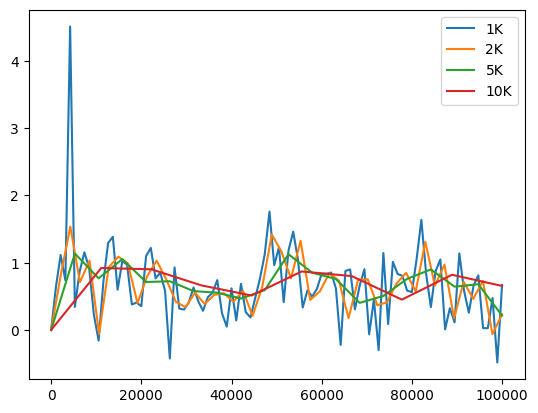

In [899]:
plt.plot(np.linspace(0,100000,len(BF_Q_gp_1K)),np.log10(BF_Q_gp_1K),label="1K")
plt.plot(np.linspace(0,100000,len(BF_Q_gp_2K)),np.log10(BF_Q_gp_2K),label="2K")
plt.plot(np.linspace(0,100000,len(BF_Q_gp_5K)),np.log10(BF_Q_gp_5K),label="5K")
plt.plot(np.linspace(0,100000,len(BF_Q_gp_10K)),np.log10(BF_Q_gp_10K),label="10K")
plt.legend()


# Test true posterior GP

Empiric Mean = 1.18E+03, Std = 1.28E+03
Theoric Mean = 1.11E+03, Std = 1.24E+03


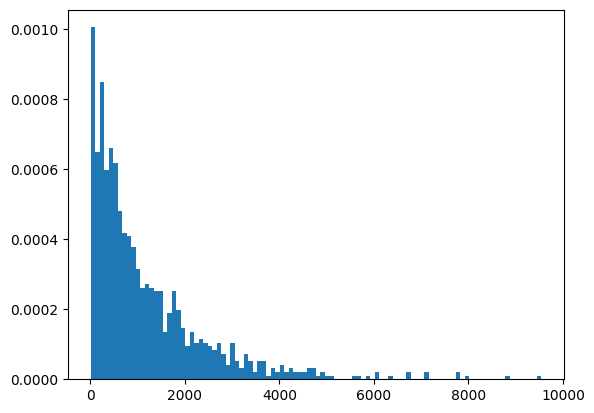

In [509]:
loc_test = 0
scale_test = 1000
shape_test = 1/10
law = genpareto(loc=loc_test,scale=scale_test,c=shape_test)
Y_test = law.rvs(1001)
plt.hist(Y_test,bins=100,density=True);
P_test = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]
#P_test = np.linspace(.01,.99,99)
Q_test = np.quantile(Y_test,P_test)
Q_test = law.ppf(P_test)
print("Empiric Mean = {:.2E}, Std = {:.2E}".format(np.mean(Y_test), np.std(Y_test)))
print("Theoric Mean = {:.2E}, Std = {:.2E}".format(law.mean(), law.std()))

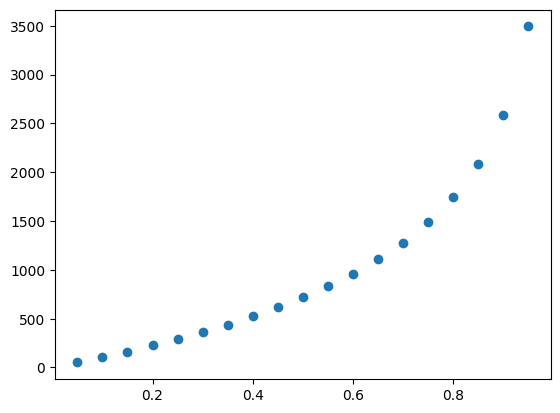

In [491]:
plt.scatter(P_test,Q_test)

0.25 0.1767766952966369


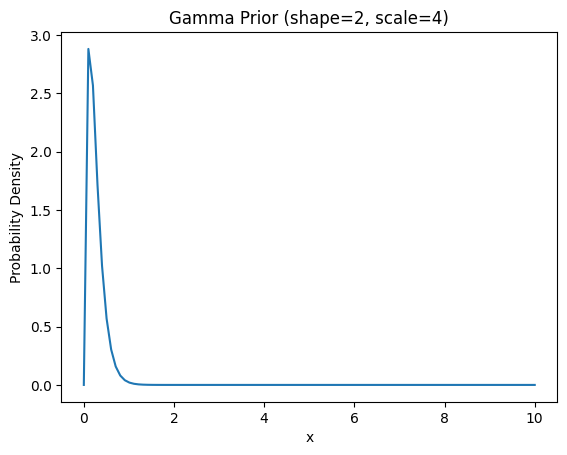

In [687]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

shape = 2
scale = 1/8
law =  gamma(a=shape, scale=scale)
x = np.linspace(0, 10, 100)
y = law.pdf(x)
print(law.mean(),law.std())

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gamma Prior (shape=2, scale=4)')
plt.show()


In [497]:
test = Gibbs_Quantile(0000,1001,Q_test,P_test,"generalized_pareto",
                      prior_loc="normal",par_prior_loc=[0,1000],std_prop_loc=3,
                      prior_scale = "gamma",par_prior_scale=[4,1000],std_prop_scale=190,
                      prior_shape=  "gamma",par_prior_shape=[2,1/8],std_prop_shape=.2,
                      reparametrization=False,verbose=True,epsilon=.1)
                      
                      

Init...
Avant reparametrization 38.150451341123464 1072.0088483429572 0.1
Après reparametrization 38.150451341123464 1072.0088483429572 0.1
In Quantile_init : init_theta = [38.150451341123464, 1072.0088483429572, 0.1]
A supprimere : Init_theta = [38.150451341123464, 1072.0088483429572, 0.1] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 51. 101. 151. 201. 251. 301. 351. 401. 451. 501. 551. 601. 651. 701.
 751. 801. 851. 901. 951.]


100%|██████████| 50000/50000 [03:08<00:00, 265.43it/s]


I= [ 51. 101. 151. 201. 251. 301. 351. 401. 451. 501. 551. 601. 651. 701.
 751. 801. 851. 901. 951.] Q.shape= (0, 50001)
Acceptation rates MH : loc = 24.43% scale = 23.42% shape = 16.93% 


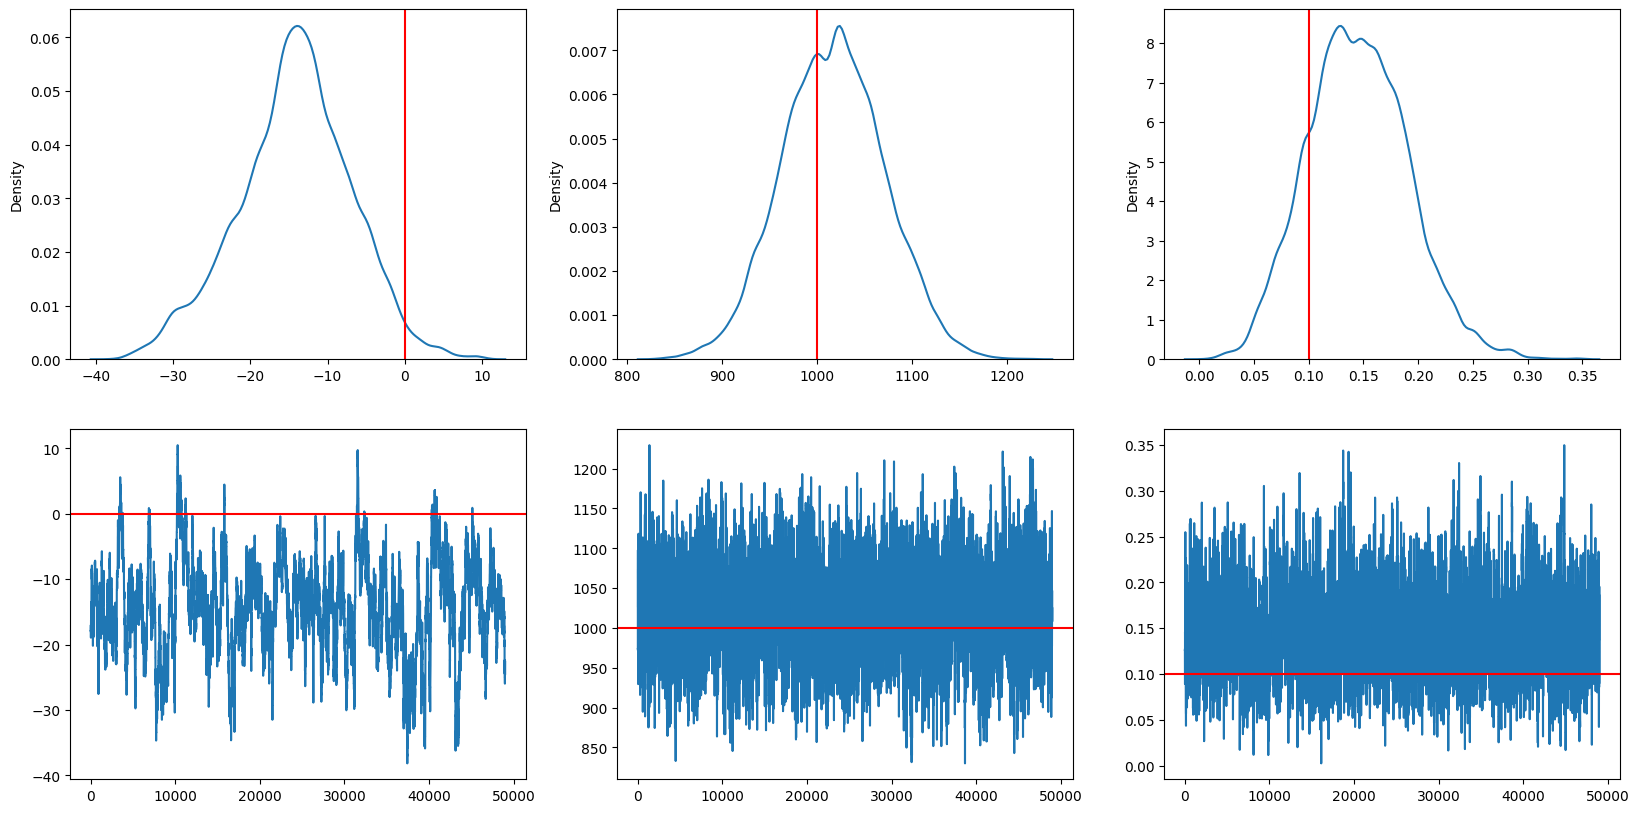

In [498]:
display(test,1000,[loc_test,scale_test,shape_test])

In [516]:
test = Gibbs_Quantile(50000,1001,Q_test,P_test,"generalized_pareto",
                      prior_loc="normal",par_prior_loc=[0,1000],std_prop_loc=3,
                      prior_scale = "gamma",par_prior_scale=[4,1000],std_prop_scale=50,
                      prior_shape=  "gamma",par_prior_shape=[4,1000],std_prop_shape=100,
                      reparametrization=True,verbose=True,epsilon=.1)
                      
                      

Init...
Avant reparametrization 50.42506969999796 999.9999999999993 0.1
Après reparametrization 50.42506969999796 1161.5361808111084 1242.2599874998823
In Quantile_init : init_theta = [50.42506969999796, 1161.5361808111084, 1242.2599874998823]
A supprimere : Init_theta = [50.42506969999796, 1161.5361808111084, 1242.2599874998823] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 51. 101. 151. 201. 251. 301. 351. 401. 451. 501. 551. 601. 651. 701.
 751. 801. 851. 901. 951.]


100%|██████████| 50000/50000 [03:24<00:00, 244.57it/s]


I= [ 51. 101. 151. 201. 251. 301. 351. 401. 451. 501. 551. 601. 651. 701.
 751. 801. 851. 901. 951.] Q.shape= (0, 50001)
Acceptation rates MH : loc = 24.36% scale = 54.21% shape = 56.62% 


In [ ]:
law

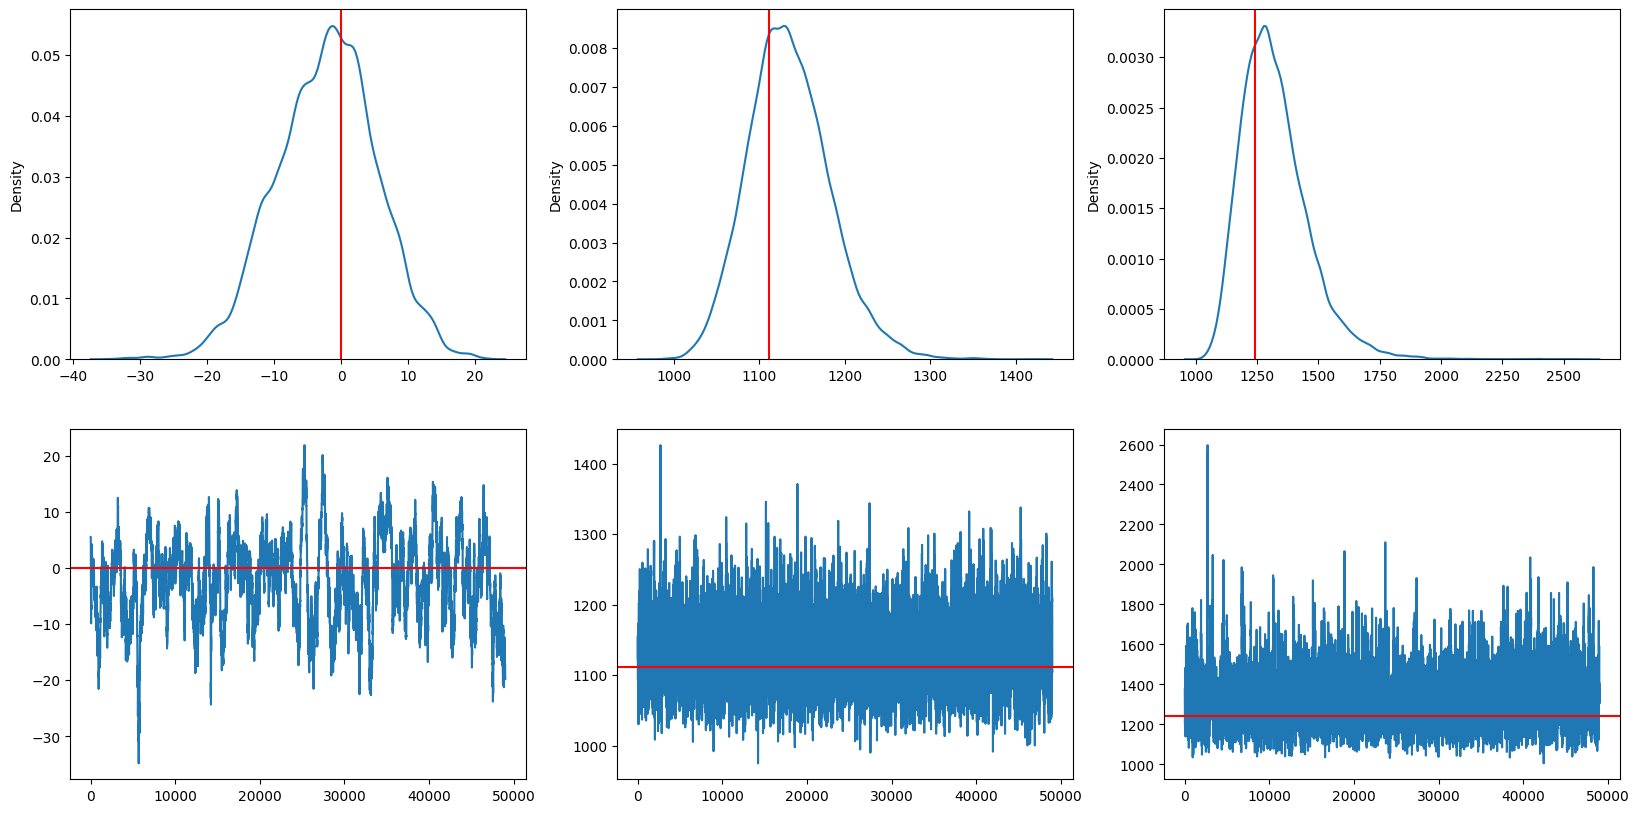

In [517]:
display(test,1000,[loc_test,law.mean(),law.std()])